In [1]:
import sys, os
os.path.dirname(sys.executable)
sys.path.append('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/')
from ESMCBA.imports import * 
from ESMCBA import other_utils
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [2]:
# results = aggregate_results(results_files, run_id_level=-2)

In [3]:
# results.to_csv('untargetted_anchoring_RFD.csv', index=False)
results = pd.read_csv('../../../untargetted_anchoring_RFD.csv')

In [4]:
rfd_peptides_all = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/rdfiffusion_output_peptides.csv')

In [5]:
results['pdb_id'] = results['RUN'].str.split('/',expand= True)[6]

In [6]:
results = pd.merge(
    results,
    rfd_peptides_all[['hla_allele','pdb_id']].drop_duplicates(),
    on=['pdb_id'],
    how='left')

In [7]:
def build_pwm(df: pd.DataFrame,
              seq_col: str,
              allele_col: str,
              length: int = 9,
              pseudocount: int = 1):
    """
    Return {allele: (L, 20) numpy array} where rows = positions,
    columns = AA probabilities.
    Only sequences of exact 'length' are used.
    """
    pwm = {}
    for hla, grp in df[df[seq_col].str.len() == length].groupby(allele_col):
        counts = np.zeros((length, 20))
        for seq in grp[seq_col]:
            for i, aa in enumerate(seq):
                if aa in AA:
                    counts[i, AA.index(aa)] += 1
        counts += pseudocount
        pwm[hla] = counts / counts.sum(axis=1, keepdims=True)
    return pwm

In [8]:
results['epitope'] = results['seq'].str.split('/', expand=True)[1]

In [9]:
import numpy as np

In [10]:
import logomaker

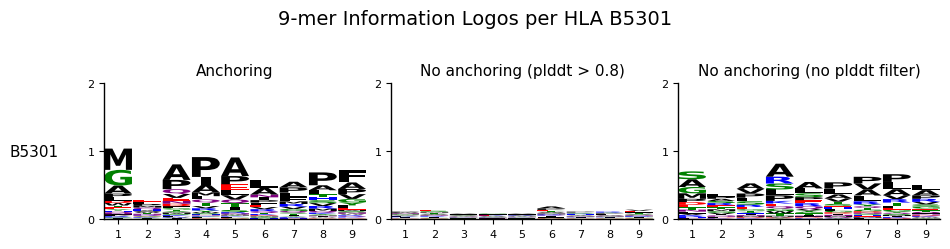

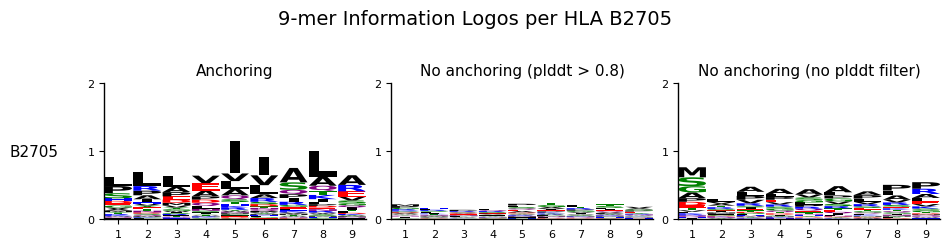

In [11]:

AA = list("ACDEFGHIKLMNPQRSTVWY")   # 20-aa alphabet
PSEUDOCOUNT = 1                     # avoids log(0) and /0 problems
PEPTIDE_LEN = 9                     # change to 8, 10, 11… if needed
RNG_SEED     = 42                   # global reproducibility


# -----------------------------------------------------------------------------
#  Assumes pwm_pred, pwm_train, pwm_episcan already exist in memory (9-mer PWM).
# -----------------------------------------------------------------------------
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
bg_probs    = [1/20] * 20       

for allele in rfd_peptides_all[rfd_peptides_all['hla_allele'].notna()]['hla_allele'].unique()[:2]:

    pwm_pred     = build_pwm(rfd_peptides_all[(rfd_peptides_all['plddt'] > 0.6) & (rfd_peptides_all['hla_allele'] == allele)],
                            seq_col="epitope",  allele_col="hla_allele")

    pwm_train     = build_pwm(results[(results['plddt'] > 0.8) & (results['hla_allele'] == allele)],
                        seq_col="epitope",  allele_col="hla_allele")

    pwm_train2     = build_pwm(results[(results['plddt'] > 0 ) & (results['hla_allele'] == allele)],
                        seq_col="epitope",  allele_col="hla_allele")
    datasets = {
        "Anchoring":        pwm_pred,
        "No anchoring (plddt > 0.8)":  pwm_train,
        "No anchoring (no plddt filter)":  pwm_train2
    }

    # only alleles present in every dataset
    common_hlas = sorted(set.intersection(*(set(d) for d in datasets.values())))

    if not common_hlas:
        continue
    #     raise ValueError("No common HLA alleles across all three datasets.")

    n_rows = len(common_hlas)
    n_cols = len(datasets)

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols * 3.2, n_rows * 2.4),
        squeeze=False
    )

    for r, hla in enumerate(common_hlas):
        for c, (src_name, pwm_dict) in enumerate(datasets.items()):
            ax = axes[r][c]
            pwm = pwm_dict[hla]             # shape (9, 20) frequencies
            freq_df = pd.DataFrame(pwm, columns=amino_acids)

            # convert to information content (bits above uniform)
            info_df = logomaker.transform_matrix(
                freq_df,
                from_type="probability",
                to_type="information",
                background=bg_probs
            )

            logo = logomaker.Logo(
                info_df,
                ax=ax,
                color_scheme="chemistry"
            )
            logo.style_spines(visible=False)
            logo.style_spines(spines=['left', 'bottom'], visible=True)

            ax.set_xticks(range(pwm.shape[0]))
            ax.set_xticklabels([str(i + 1) for i in range(pwm.shape[0])], fontsize=8)
            ax.set_ylabel("")

            # Column headers
            if r == 0:
                ax.set_title(src_name, fontsize=11, pad=6)

            # Row labels
            if c == 0:
                ax.set_ylabel(hla, rotation=0, fontsize=11,
                            labelpad=38, va="center")

            # Clean y‑axis ticks
            ax.set_yticks([0, 1, 2])
            ax.set_yticklabels(["0", "1", "2"], fontsize=8)

    plt.suptitle(f"9‑mer Information Logos per HLA {allele}", fontsize=14, y=1.02)
    plt.tight_layout(h_pad=0.6, w_pad=0.6)
    plt.show()


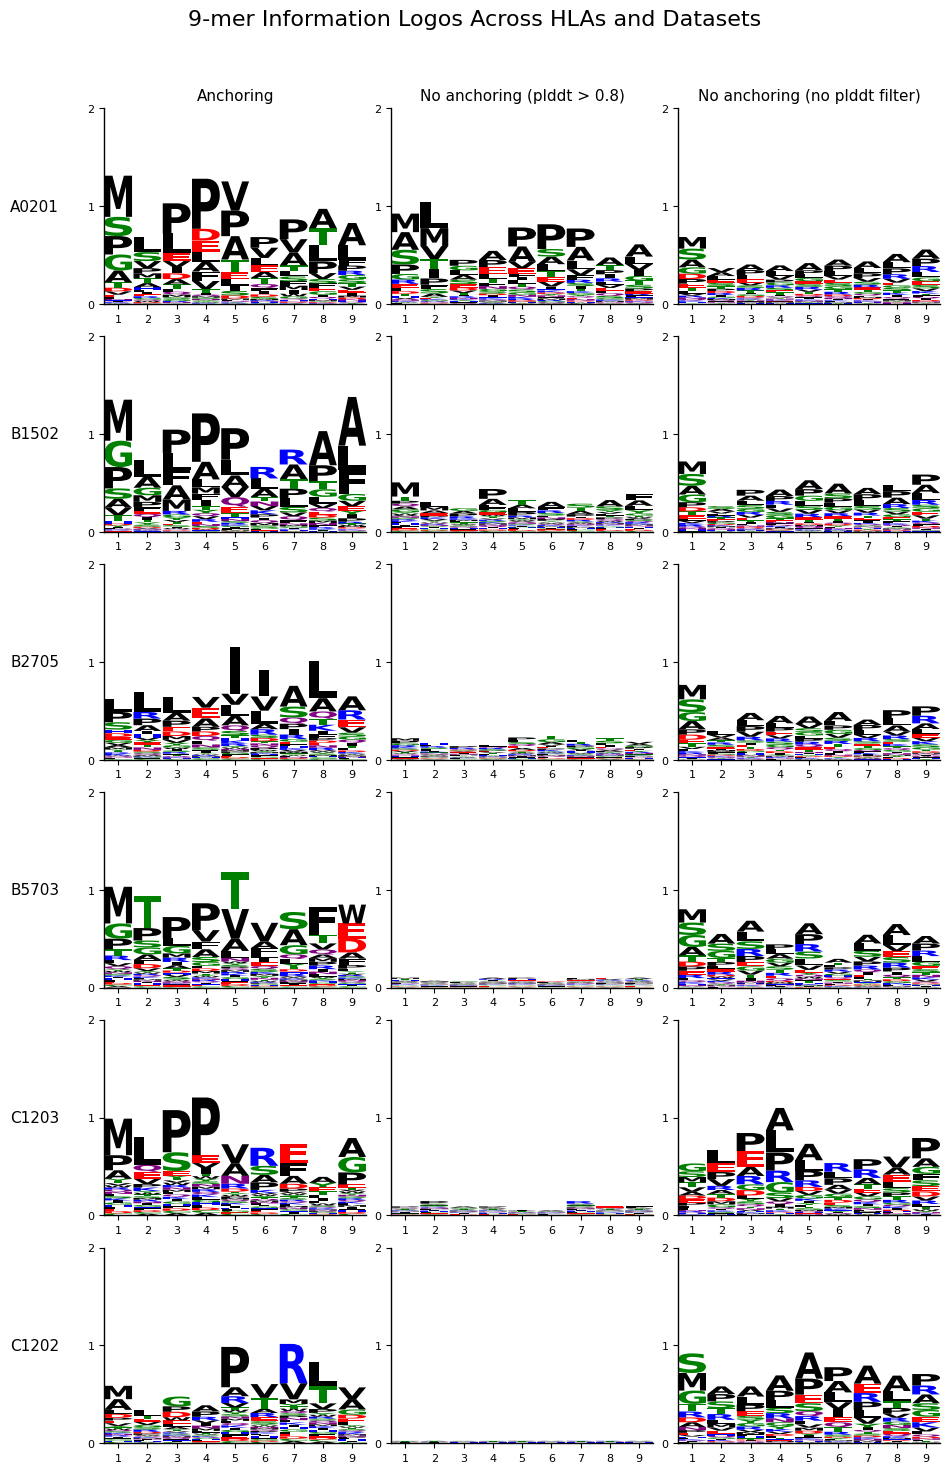

In [12]:

amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
bg_probs = [1 / 20] * 20
alleles =  ['A0201','B1502', 'B2705', 'B5703', 'C1203','C1202'] #rfd_peptides_all[rfd_peptides_all['hla_allele'].notna()]['hla_allele'].unique()
datasets_names = ["Anchoring", "No anchoring (plddt > 0.8)", "No anchoring (no plddt filter)"]

n_rows = len(alleles)
n_cols = len(datasets_names)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3.2, n_rows * 2.4), squeeze=False)

for row_idx, allele in enumerate(alleles):

    pwm_pred     = build_pwm(rfd_peptides_all[(rfd_peptides_all['plddt'] > 0.6) & (rfd_peptides_all['hla_allele'] == allele)],
                            seq_col="epitope",  allele_col="hla_allele")

    pwm_train     = build_pwm(results[(results['plddt'] > 0.8) & (results['hla_allele'] == allele)],
                        seq_col="epitope",  allele_col="hla_allele")

    pwm_train2     = build_pwm(results[(results['plddt'] > 0 ) & (results['hla_allele'] == allele)],
                        seq_col="epitope",  allele_col="hla_allele")

    datasets = {
        "Anchoring": pwm_pred,
        "No anchoring (plddt > 0.8)": pwm_train,
        "No anchoring (no plddt filter)": pwm_train2
    }

    common_hlas = sorted(set.intersection(*(set(d) for d in datasets.values())))
    if not common_hlas:
        continue

    hla = common_hlas[0]  # pick one if only one per allele anyway

    for col_idx, (dataset_name, pwm_dict) in enumerate(datasets.items()):
        ax = axes[row_idx][col_idx]
        pwm = pwm_dict[hla]
        freq_df = pd.DataFrame(pwm, columns=amino_acids)
        info_df = logomaker.transform_matrix(freq_df, from_type="probability", to_type="information", background=bg_probs)

        logo = logomaker.Logo(info_df, ax=ax, color_scheme="chemistry")
        logo.style_spines(visible=False)
        logo.style_spines(spines=['left', 'bottom'], visible=True)

        ax.set_xticks(range(pwm.shape[0]))
        ax.set_xticklabels([str(i + 1) for i in range(pwm.shape[0])], fontsize=8)
        ax.set_yticks([0, 1, 2])
        ax.set_yticklabels(["0", "1", "2"], fontsize=8)
        ax.set_ylabel("")

        if row_idx == 0:
            ax.set_title(dataset_name, fontsize=11, pad=6)
        if col_idx == 0:
            ax.set_ylabel(allele, rotation=0, fontsize=11, labelpad=38, va="center")

plt.suptitle("9-mer Information Logos Across HLAs and Datasets", fontsize=16, y=1.02)
plt.tight_layout(h_pad=0.6, w_pad=0.6)
# plt.savefig("9mer_logos2.pdf", dpi=300, bbox_inches="tight")


In [13]:
# Load the shared peptide datasets
rfd_peptides_all = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/rdfiffusion_output_peptides.csv')
peptides_eval_set_ESMCBA = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/performances/predictions_of_models.csv')


In [14]:
results = []

for file in glob.glob('/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/*epitope*umap.csv'):
    print(file)
    df = pd.read_csv(file)
    df['dataset'] = file.split('/')[-1].split('_')[0]
    results.append(df)
    
results = pd.concat(results)

/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/B0801_epitope-B0801_umap.csv
/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/A0201_epitope-A0201_umap.csv
/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/B3801_epitope-B3801_umap.csv
/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/B5101_epitope-B5101_umap.csv
/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/A2601_epitope-A2601_umap.csv
/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/B5701_epitope-B5701_umap.csv
/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/B4402_epitope-B4402_umap.csv
/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/C0701_epitope-C0701_umap.csv
/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/A3001_epitope-A3001_umap.csv
/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/A3301_epitope-A3301_umap.csv
/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/A1101_epitope-A1101_umap.csv
/global/scratch/users/sergiomar10/benchmark

In [15]:
rfd_peptides = rfd_peptides_all[['Unnamed: 0', 'design', 'n', 'mpnn', 'plddt', 'i_ptm', 'i_pae', 'rmsd','hla_allele', 'epitope',
       'length']]
       
rfd_peptides.drop_duplicates()

,Unnamed: 0,design,n,mpnn,plddt,i_ptm,i_pae,rmsd,hla_allele,epitope,length
0,0,0,0,1.113492,0.372247,0.583565,16.372119,4.524031,B5301,MHPTTLAAL,9
1,1,0,1,1.135099,0.317034,0.513891,17.844706,7.646739,B5301,MHPTELAAL,9
2,2,0,2,1.219426,0.312529,0.488811,17.909068,5.255136,B5301,MHPIEAAAR,9
3,3,0,3,1.273745,0.293993,0.511861,17.962950,7.499096,B5301,MHPTEAAAR,9
4,4,0,4,1.177355,0.345040,0.521039,17.675305,4.432161,B5301,MHPTTLAAQ,9
...,...,...,...,...,...,...,...,...,...,...,...
174215,13,0,13,1.017397,0.814953,0.894123,7.672453,4.979321,B1502,MPPPPTSAL,9
174216,17,0,17,1.034457,0.282566,0.498632,18.117292,6.189767,B1502,MAPAPVAAL,9
174217,20,0,20,0.921892,0.693165,0.810597,10.032635,5.016969,B1502,MPPAPVSAL,9
174218,28,0,28,0.948689,0.479862,0.639445,14.413845,4.871328,B1502,MVPAPVSAL,9


In [16]:
merged_df = pd.merge(results, rfd_peptides, left_on='sequence', right_on='epitope', how='left')
merged_df

,sequence,prediction,UMAP_1,UMAP_2,dataset,Unnamed: 0,design,n,mpnn,plddt,i_ptm,i_pae,rmsd,hla_allele,epitope,length
0,GRAKLLGAEEK,3.967471,1.288819,4.774697,B0801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,RAKLLGAEEK,3.765067,1.380595,4.851659,B0801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LAKLLGAEEK,3.832964,-0.122071,5.953277,B0801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HVKITDFGL,3.375636,3.360707,7.100804,B0801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FGLAKLLGA,3.296010,3.477158,9.123614,B0801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415854,AHYFGVASE,3.606437,1.422855,8.764668,A3101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415855,PPNPPFWPD,4.229715,-1.119684,4.701636,A3101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415856,TANYYPCYV,3.002676,0.071857,10.254654,A3101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415857,RENKLPKCY,4.129143,-0.635344,6.252912,A3101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
merged_df = merged_df[merged_df['n'].notna()] #['hla_allele'].nunique()
merged_df

,sequence,prediction,UMAP_1,UMAP_2,dataset,Unnamed: 0,design,n,mpnn,plddt,i_ptm,i_pae,rmsd,hla_allele,epitope,length
24020,SDLSLGPEA,5.025822,5.581143,4.680666,A0201,0.0,0.0,0.0,1.062539,0.286750,0.463192,18.742739,6.944140,A0201,SDLSLGPEA,9.0
24021,SSLSLGPEA,5.024071,5.430584,4.642436,A0201,1.0,0.0,1.0,1.055919,0.286837,0.482738,18.281505,7.346444,A0201,SSLSLGPEA,9.0
24022,SSLSLGPHA,4.819687,5.158812,4.731397,A0201,2.0,0.0,2.0,1.129460,0.288033,0.483671,18.362026,6.773100,A0201,SSLSLGPHA,9.0
24023,SSLSLGFHA,4.007002,4.627771,4.790965,A0201,5.0,0.0,5.0,1.069345,0.406397,0.607049,16.149750,12.260466,A0201,SSLSLGFHA,9.0
24024,SDLSLGFEA,4.278176,5.205836,4.650356,A0201,7.0,0.0,7.0,1.103003,0.309058,0.502179,18.039161,6.099219,A0201,SDLSLGFEA,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246505,YVNPDAGAA,3.865093,-0.627353,7.133856,B1501,22.0,0.0,22.0,1.436621,0.340256,0.519495,17.429933,10.131607,B1501,YVNPDAGAA,9.0
246506,YIEPDAGAA,3.911218,-0.663394,7.097418,B1501,24.0,0.0,24.0,1.393617,0.268060,0.444812,19.055830,6.053535,B1501,YIEPDAGAA,9.0
246507,YIDPTAGAA,3.980139,-0.656323,7.104160,B1501,26.0,0.0,26.0,1.422590,0.291395,0.479514,18.330882,8.971364,B1501,YIDPTAGAA,9.0
246508,YINPDAGAG,3.283753,2.079319,4.742339,B1501,27.0,0.0,27.0,1.399309,0.276736,0.474115,18.608502,6.722735,B1501,YINPDAGAG,9.0


In [18]:
# Load the shared peptide datasets
rfd_peptides_all = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/rdfiffusion_output_peptides.csv')
peptides_eval_set_ESMCBA = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/performances/predictions_of_models.csv')

# Get list of all UMAP files
umap_files = glob.glob('/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/*epitope*_umap.csv')

# Create empty list to collect the merged DataFrames
all_predictions = []

pretty_names = {
    'measured': 'Experimental IC₅₀ Measurement',
    'mhc_log_y': 'MHCflurry log₁₀ IC₅₀ Prediction',
    'BA_Rank': 'NetMHCpan Rank',
    'prediction_x': 'ESMCBA log₁₀ IC₅₀ Prediction',
    'plddt': 'AF2 pLDDT',
    'mpnn': 'ProteinMPNN Score',
    'rmsd': 'AF2 RMSD',
    'i_pae': 'AF2 Interface PAE',
    'i_ptm': 'AF2 iPTM Score',
    'PERMUTATION_TEST' : 'Anchor-Preserved Mutagenesis Baseline',
    'RANDOM_SAMPLED' : 'Global Sequence Sampling Control'
}

sns.set_style("white")

# Now loop over each file
for file in umap_files:
    filename = os.path.basename(file)
    hla = filename.split('_')[0]  # e.g., 'B1501' from 'B1501_epitope-B1501_umap.csv'

    if 'epitope' not in filename:
        continue

    # if 'A0201' not in filename:
    #     continue

    # Load UMAP predictions
    ESCMBA_predictions = pd.read_csv(file)

    try:
        mhcflurry = pd.read_csv(f'/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/{hla}RS_RFD_MAC__mhc_flurry.csv')
        mhcflurry['mhc_log'] = mhcflurry['mhcflurry_affinity'].apply(np.log10)

        # try:
        netmhcspan = pd.read_csv(f'/global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/RS_RFD_MAC__{hla}_netmhc.xls', sep = '\t', header = 1)
        # exscept:

        # if mhc_log.empty:   
        #     print(f"Warning: No mhc_log data for {hla}. Skipping this file.")
        #     continue

        # Subset RFD peptides for this HLA
        rfd_peptides = rfd_peptides_all[rfd_peptides_all['hla_allele'] == hla]

        # Skip if no peptides
        if len(rfd_peptides) == 0:
            continue

        # Subset evaluation set
        peptides_eval = peptides_eval_set_ESMCBA[peptides_eval_set_ESMCBA['Model'] == f'{hla} epitope']

        # Merge data
        ESCMBA_predictions = pd.merge(ESCMBA_predictions, peptides_eval, on='sequence', how='left')
        ESCMBA_predictions = pd.merge(ESCMBA_predictions, rfd_peptides, left_on='sequence', right_on='epitope', how='left')
        ESCMBA_predictions = pd.merge(ESCMBA_predictions, mhcflurry[['peptide','mhc_log','mhcflurry_presentation_score']], left_on='sequence', right_on='peptide', how='left')
        ESCMBA_predictions = pd.merge(ESCMBA_predictions, netmhcspan[['Peptide','BA_Rank']], left_on='sequence', right_on='Peptide', how='left')    

        # Add a column for HLA for traceability
        ESCMBA_predictions['HLA'] = hla

        random_sampled = pd.read_csv('9mers_esm2.csv')
        # random_sampled['RANDOM_SAMPLED'] = True

        ESCMBA_predictions = pd.merge(left=ESCMBA_predictions, right=random_sampled, on='sequence', how='left')

        ESCMBA_predictions['RANDOM_SAMPLED'] = ESCMBA_predictions['sequence'].isin(random_sampled['sequence'])

        ESCMBA_predictions['PERMUTATION_TEST'] = (
        (ESCMBA_predictions['RANDOM_SAMPLED'] == False ) & (ESCMBA_predictions['plddt'].isna())
    )

        # Append this merged df to list
        all_predictions.append(ESCMBA_predictions)
    except FileNotFoundError:
        print(f"File not found for {hla}. Skipping this file. The file name is: {file}")
        continue

File not found for A0201. Skipping this file. The file name is: /global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/A0201_epitope-A0201_umap.csv
File not found for B4402. Skipping this file. The file name is: /global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/B4402_epitope-B4402_umap.csv
File not found for A1101. Skipping this file. The file name is: /global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/A1101_epitope-A1101_umap.csv
File not found for B0702. Skipping this file. The file name is: /global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/B0702_epitope-B0702_umap.csv


File not found for A0301. Skipping this file. The file name is: /global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/A0301_epitope-A0301_umap.csv
File not found for A0101. Skipping this file. The file name is: /global/scratch/users/sergiomar10/benchmark/RFD_BENCHMARK/A0101_epitope-A0101_umap.csv


In [19]:
merged_predictions = pd.concat(all_predictions)

In [20]:
#Merge merged_df with merged_predictions  on 'sequence' column
merged_dt = pd.merge(merged_df, merged_predictions, on='sequence', how='left')

In [21]:
merged_dt

,sequence,prediction,UMAP_1_x,UMAP_2_x,dataset,Unnamed: 0_x,design_x,n_x,mpnn_x,plddt_x,...,hla_allele_y,epitope_y,length_y,peptide_y,mhc_log_y,mhcflurry_presentation_score_y,Peptide_y,BA_Rank,RANDOM_SAMPLED,PERMUTATION_TEST
0,SDLSLGPEA,5.025822,5.581143,4.680666,A0201,0.0,0.0,0.0,1.062539,0.286750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SSLSLGPEA,5.024071,5.430584,4.642436,A0201,1.0,0.0,1.0,1.055919,0.286837,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SSLSLGPHA,4.819687,5.158812,4.731397,A0201,2.0,0.0,2.0,1.129460,0.288033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SSLSLGFHA,4.007002,4.627771,4.790965,A0201,5.0,0.0,5.0,1.069345,0.406397,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SDLSLGFEA,4.278176,5.205836,4.650356,A0201,7.0,0.0,7.0,1.103003,0.309058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24200,YVNPDAGAA,3.865093,-0.627353,7.133856,B1501,22.0,0.0,22.0,1.436621,0.340256,...,B1501,YVNPDAGAA,9.0,YVNPDAGAA,3.547536,0.032228,YVNPDAGAA,8.7360,False,False
24201,YIEPDAGAA,3.911218,-0.663394,7.097418,B1501,24.0,0.0,24.0,1.393617,0.268060,...,B1501,YIEPDAGAA,9.0,YIEPDAGAA,4.234543,0.006237,YIEPDAGAA,25.1504,False,False
24202,YIDPTAGAA,3.980139,-0.656323,7.104160,B1501,26.0,0.0,26.0,1.422590,0.291395,...,B1501,YIDPTAGAA,9.0,YIDPTAGAA,4.034669,0.010830,YIDPTAGAA,21.9946,False,False
24203,YINPDAGAG,3.283753,2.079319,4.742339,B1501,27.0,0.0,27.0,1.399309,0.276736,...,B1501,YINPDAGAG,9.0,YINPDAGAG,4.173962,0.006943,YINPDAGAG,9.8865,False,False


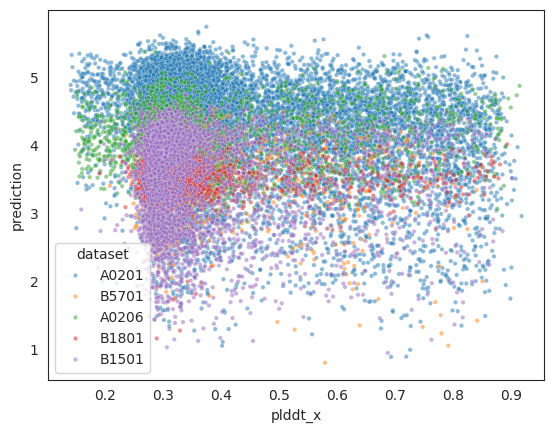

In [22]:
sns.scatterplot(data=merged_dt, x='plddt_x', y='prediction', hue='dataset', alpha=0.5, s=10)
plt.show()

#Plot the same but in bins from 0 to 1 in 0.1 steps 

In [23]:
merged_dt

,sequence,prediction,UMAP_1_x,UMAP_2_x,dataset,Unnamed: 0_x,design_x,n_x,mpnn_x,plddt_x,...,hla_allele_y,epitope_y,length_y,peptide_y,mhc_log_y,mhcflurry_presentation_score_y,Peptide_y,BA_Rank,RANDOM_SAMPLED,PERMUTATION_TEST
0,SDLSLGPEA,5.025822,5.581143,4.680666,A0201,0.0,0.0,0.0,1.062539,0.286750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SSLSLGPEA,5.024071,5.430584,4.642436,A0201,1.0,0.0,1.0,1.055919,0.286837,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SSLSLGPHA,4.819687,5.158812,4.731397,A0201,2.0,0.0,2.0,1.129460,0.288033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SSLSLGFHA,4.007002,4.627771,4.790965,A0201,5.0,0.0,5.0,1.069345,0.406397,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SDLSLGFEA,4.278176,5.205836,4.650356,A0201,7.0,0.0,7.0,1.103003,0.309058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24200,YVNPDAGAA,3.865093,-0.627353,7.133856,B1501,22.0,0.0,22.0,1.436621,0.340256,...,B1501,YVNPDAGAA,9.0,YVNPDAGAA,3.547536,0.032228,YVNPDAGAA,8.7360,False,False
24201,YIEPDAGAA,3.911218,-0.663394,7.097418,B1501,24.0,0.0,24.0,1.393617,0.268060,...,B1501,YIEPDAGAA,9.0,YIEPDAGAA,4.234543,0.006237,YIEPDAGAA,25.1504,False,False
24202,YIDPTAGAA,3.980139,-0.656323,7.104160,B1501,26.0,0.0,26.0,1.422590,0.291395,...,B1501,YIDPTAGAA,9.0,YIDPTAGAA,4.034669,0.010830,YIDPTAGAA,21.9946,False,False
24203,YINPDAGAG,3.283753,2.079319,4.742339,B1501,27.0,0.0,27.0,1.399309,0.276736,...,B1501,YINPDAGAG,9.0,YINPDAGAG,4.173962,0.006943,YINPDAGAG,9.8865,False,False


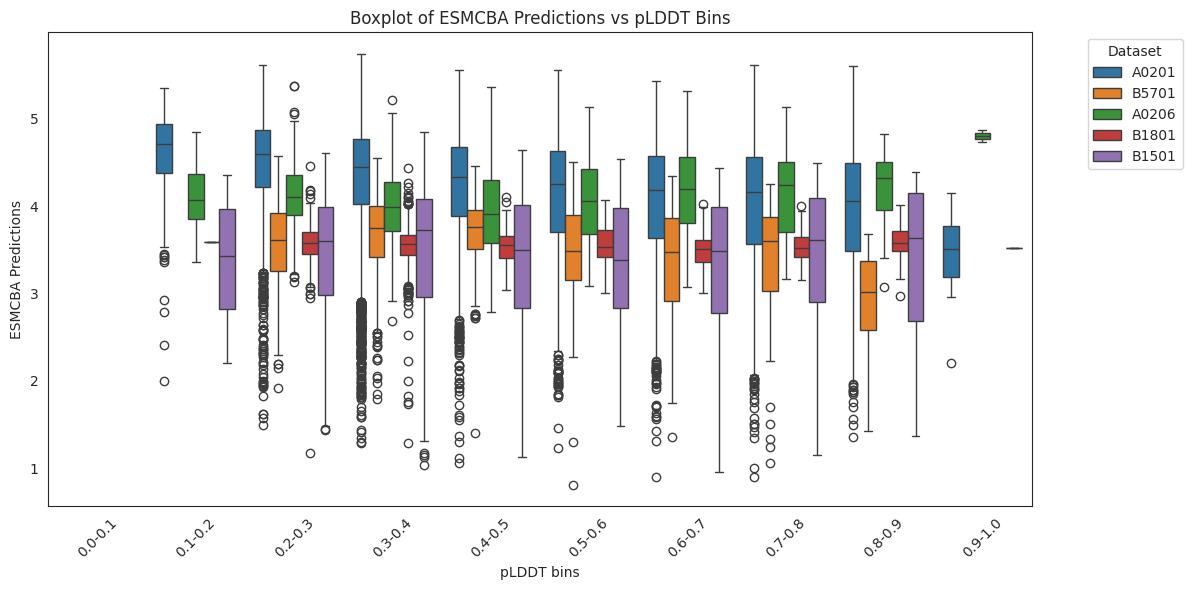

In [24]:
# Define clear bins and labels explicitly
bins = np.arange(0, 1.1, 0.1)
labels = [f"{round(bins[i], 1)}-{round(bins[i+1], 1)}" for i in range(len(bins)-1)]

# Create bins with labels
merged_dt['plddt_x_bins'] = pd.cut(merged_dt['plddt_x'], bins=bins, labels=labels, include_lowest=True)

# Now plot them in boxplots clearly
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_dt, x='plddt_x_bins', y='prediction', hue='dataset')

# Formatting the plot
plt.title('Boxplot of ESMCBA Predictions vs pLDDT Bins')
plt.xlabel('pLDDT bins')
plt.ylabel('ESMCBA Predictions')

# Rotate labels for clarity
plt.xticks(rotation=45)

plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()



/tmp/ipykernel_2030438/3557268749.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')


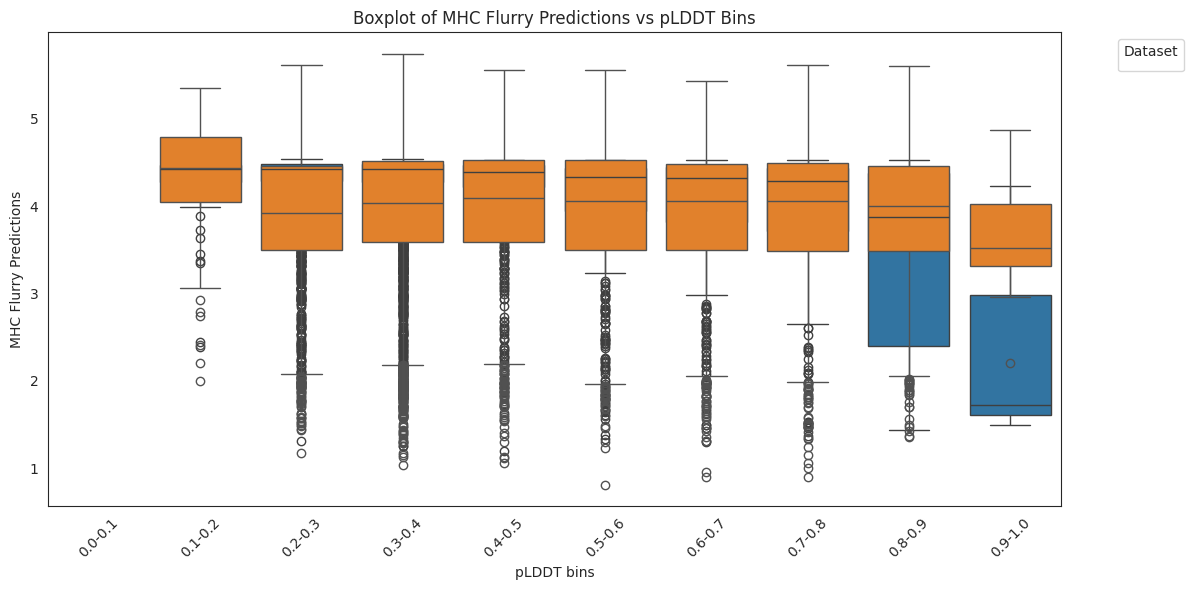

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_dt, x='plddt_x_bins', y='mhc_log_y') #, hue='dataset')
sns.boxplot(data=merged_dt, x='plddt_x_bins', y='prediction') #, hue='dataset')
# sns.boxplot(data=merged_dt, x='plddt_x_bins', y='BA_Rank') #, hue='dataset')

# Formatting the plot
plt.title('Boxplot of MHC Flurry Predictions vs pLDDT Bins')
plt.xlabel('pLDDT bins')
plt.ylabel('MHC Flurry Predictions')

# Rotate labels for clarity
plt.xticks(rotation=45)

plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Axes: xlabel='UMAP_1_x', ylabel='UMAP_2_x'>

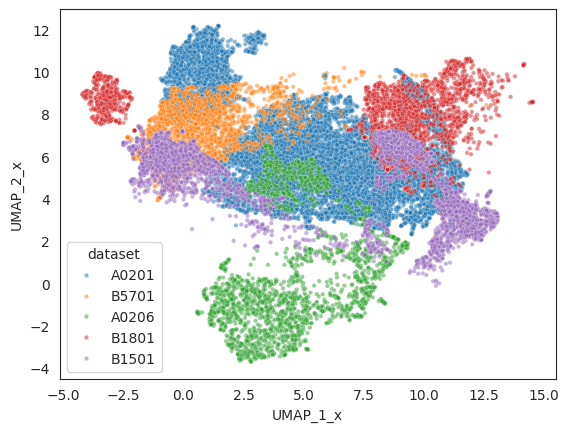

In [26]:
sns.scatterplot(data=merged_dt, x='UMAP_1_x', y='UMAP_2_x', hue='dataset', alpha=0.5, s=10)

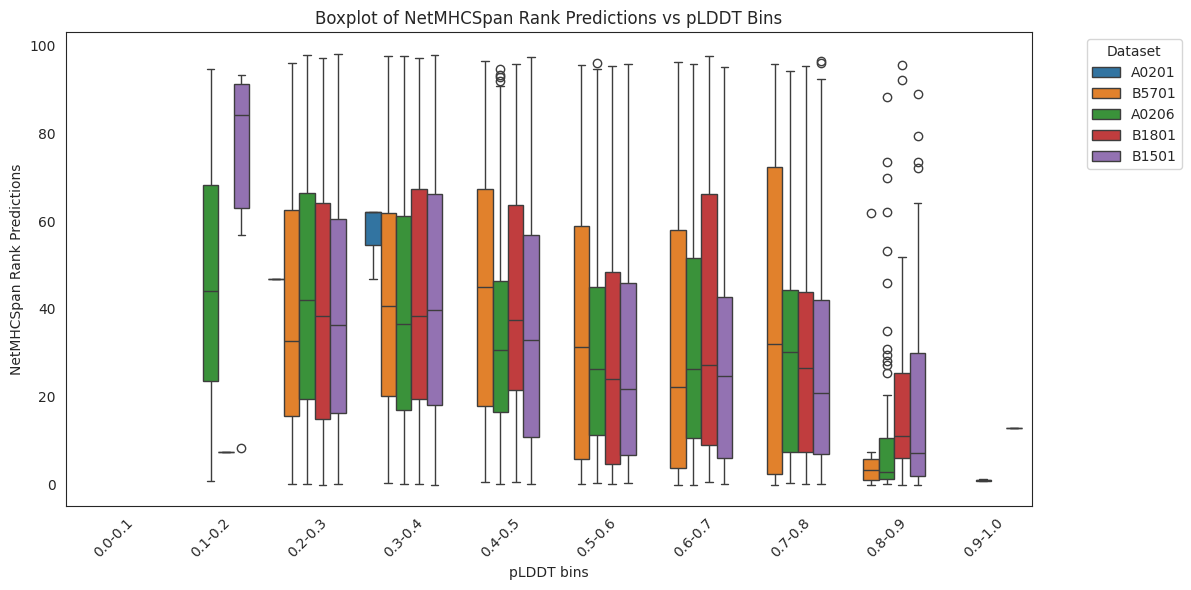

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_dt, x='plddt_x_bins', y='BA_Rank', hue='dataset')

# Formatting the plot
plt.title('Boxplot of NetMHCSpan Rank Predictions vs pLDDT Bins')
plt.xlabel('pLDDT bins')
plt.ylabel('NetMHCSpan Rank Predictions')

# Rotate labels for clarity
plt.xticks(rotation=45)

plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Axes: >

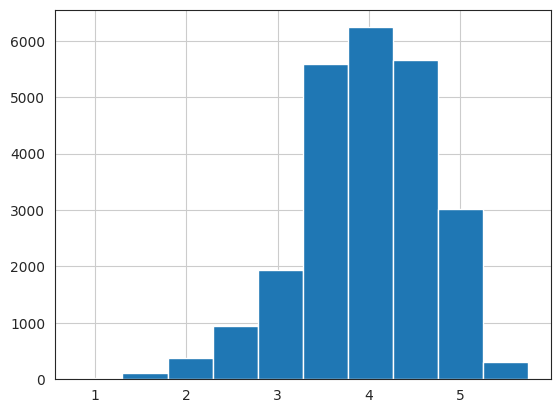

In [28]:
merged_dt['prediction'].hist()

<Axes: >

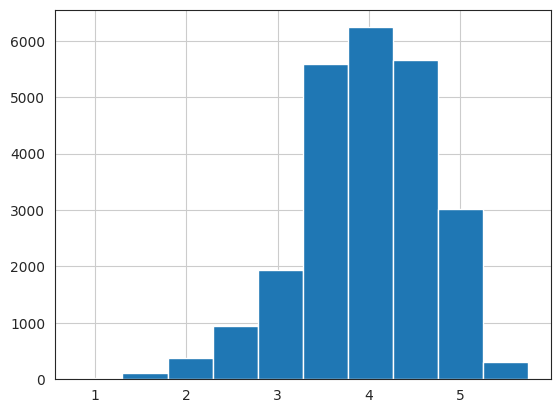

In [29]:
merged_dt['prediction'].hist()

<Axes: >

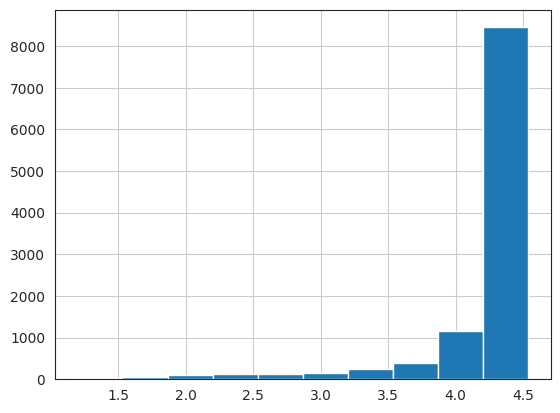

In [30]:
merged_dt['mhc_log_y'].hist()

<Axes: >

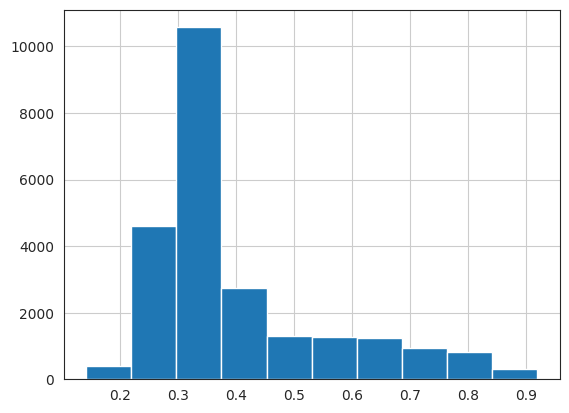

In [31]:
merged_dt['plddt_x'].hist()

<Axes: >

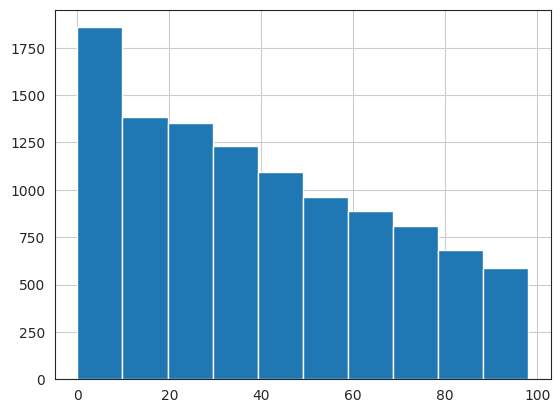

In [32]:
merged_dt['BA_Rank'].hist()

In [33]:
results = []

for i in glob.glob('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/input_*output.csv'):
    # print(i)
    df = pd.read_csv(i)
    df['dataset'] = i.split('/')[-1].split('_')[0]
    results.append(df)

results_apollo = pd.concat(results)
results_apollo.head()

,allele,peptide,n_flank,c_flank,invalid_allele,invalid_aa,invalid_length,train_allele,peptide_length,mhc_pred_0,mhc_pred_0_rank,dataset
0,B*18:01,PVAEALAA,**********,**********,False,False,False,True,8,-41.260389,43.738108,input
1,B*18:01,GDTTVALLLA,**********,**********,False,False,False,True,10,-38.732992,12.156723,input
2,B*18:01,GDETVRLLLE,**********,**********,False,False,False,True,10,-39.569536,18.609171,input
3,B*18:01,GDEGVALLLA,**********,**********,False,False,False,True,10,-38.752521,12.276692,input
4,B*18:01,GSKTVALLLE,**********,**********,False,False,False,True,10,-41.122284,40.977226,input


In [34]:
results_apollo[['peptide','mhc_pred_0']]

,peptide,mhc_pred_0
0,PVAEALAA,-41.260389
1,GDTTVALLLA,-38.732992
2,GDETVRLLLE,-39.569536
3,GDEGVALLLA,-38.752521
4,GSKTVALLLE,-41.122284
...,...,...
2187,LWLEIDALER,-42.165773
2188,LELAIDALER,-40.830015
2189,LELAIDAKMT,-41.881873
2190,LWLAIDALMR,-42.517180


In [35]:
merged_dta = pd.merge(merged_dt, results_apollo[['peptide','mhc_pred_0']], left_on='sequence', right_on='peptide', how='left')
merged_dta = merged_dta.drop_duplicates()
merged_dta.to_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/merged_dta.csv', index=False)

In [36]:
# merged_dta2 = pd.merge(merged_dta, predictions_hlas[['sequence','HLAthena_predictions']], left_on='sequence', right_on='sequence', how='left')

In [37]:
predictions_hlas = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/paper_predictions_with_hlathena.csv')
predictions_hlas
merged_dta2 = pd.merge(merged_dta, predictions_hlas[['sequence','HLAthena_predictions']], left_on='sequence', right_on='sequence', how='left')

/tmp/ipykernel_2030438/1696922135.py:1: DtypeWarning: Columns (62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  predictions_hlas = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/paper_predictions_with_hlathena.csv')


In [38]:
merged_dta2.to_csv('/global/scratch/users/sergiomar10/STRUCTMHCBENCHMARK/struct-mhc-benchmark-1/benchmark-data/dataframe_predictions.csv', index=False)

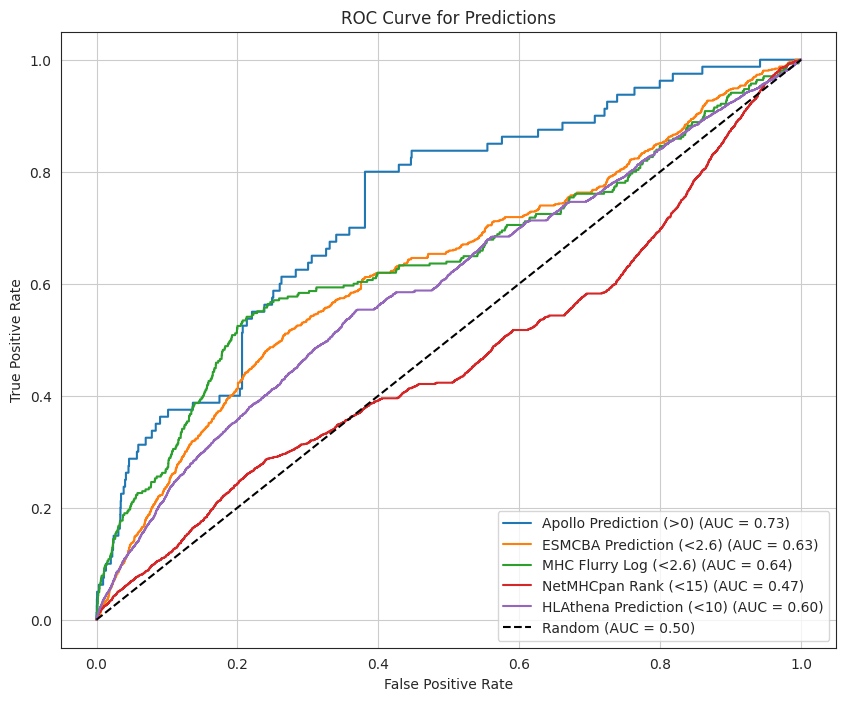

In [39]:



###GET FROM HERE
from sklearn.metrics import roc_curve, auc

# Define binary labels for each column based on your criteria
merged_dta2['apollo_label'] = (merged_dta2['mhc_pred_0'] > 0).astype(int)
merged_dta2['prediction_label'] = (merged_dta2['prediction'] < 2.5).astype(int)
merged_dta2['mhc_log_y_label'] = (merged_dta2['mhc_log_y'] < 2.5).astype(int)
merged_dta2['BA_Rank_label'] = (merged_dta2['BA_Rank'] < 15).astype(int)
merged_dta2['HLA_athnea_label'] = (merged_dta2['HLAthena_predictions'] < 10).astype(int)


# Predictors (use plddt_x as the predictor variable for all three models)
predictor = merged_dta2['plddt_x']

# Plot ROC curves
plt.figure(figsize=(10, 8))

labels_and_names = [
    ('apollo_label', 'Apollo Prediction (>0)'),
    ('prediction_label', 'ESMCBA Prediction (<2.6)'),
    ('mhc_log_y_label', 'MHC Flurry Log (<2.6)'),
    ('BA_Rank_label', 'NetMHCpan Rank (<15)'),
    ('HLA_athnea_label', 'HLAthena Prediction (<10)')
]

for label_col, name in labels_and_names:
    fpr, tpr, _ = roc_curve(merged_dta2[label_col], predictor)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot random guess baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

# Labels and formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Predictions')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [40]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 8))

# for pred_col, name in model_preds:
#     # Keep only rows where both predictor and label are not NaN
#     valid = merged_dta2[['high_plddt_label', pred_col]].dropna()
    
#     # If using IC50, BA_Rank, or similar where lower = better, negate the prediction
#     scores = -valid[pred_col]  # flip if lower = stronger binder
#     labels = valid['high_plddt_label']
    
#     fpr, tpr, _ = roc_curve(labels, scores)
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC: Can predictions classify high-structure-confidence peptides?')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()


In [41]:
merged_dta2[['plddt_x','mhc_pred_0','prediction','mhc_log_y','BA_Rank','HLAthena_predictions']]

,plddt_x,mhc_pred_0,prediction,mhc_log_y,BA_Rank,HLAthena_predictions
0,0.286750,-38.507525,5.025822,NaN,NaN,16.979229
1,0.286837,-37.665597,5.024071,NaN,NaN,20.103130
2,0.288033,-39.210855,4.819687,NaN,NaN,22.473854
3,0.406397,-37.809690,4.007002,NaN,NaN,26.340936
4,0.309058,-37.442533,4.278176,NaN,NaN,20.744816
...,...,...,...,...,...,...
27212,0.340256,-38.649507,3.865093,3.547536,8.7360,15.904532
27213,0.268060,-43.580001,3.911218,4.234543,25.1504,15.959032
27214,0.291395,-41.281255,3.980139,4.034669,21.9946,44.300589
27215,0.276736,-42.826305,3.283753,4.173962,9.8865,44.670989


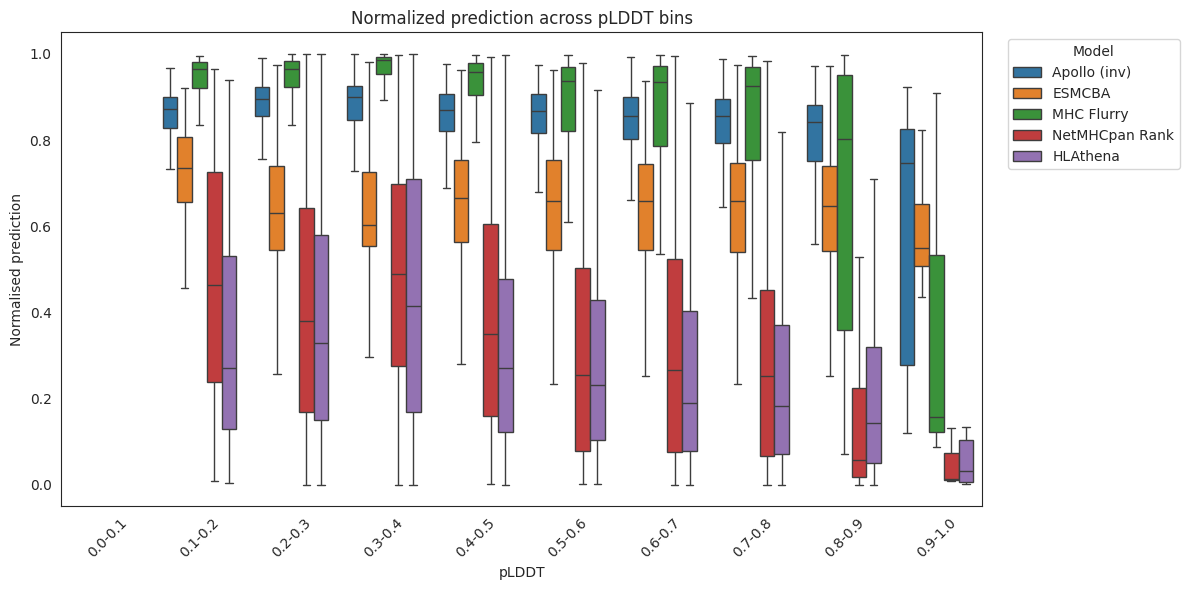

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Work on a copy to keep the original intact
df = merged_dta2.copy()

# ──────────────────────────────────────────────────────────────
# 1.  Create pLDDT bins in steps of 0.10
# ──────────────────────────────────────────────────────────────
edges  = np.arange(0, 1.01, 0.10)                 # 0.0, 0.1, …, 1.0
labels = [f'{edges[i]:.1f}-{edges[i+1]:.1f}' for i in range(len(edges) - 1)]
df['pLDDT_bin'] = pd.cut(df['plddt_x'],
                         bins=edges,
                         labels=labels,
                         include_lowest=True)

# ──────────────────────────────────────────────────────────────
# 2.  Prediction columns and display names
#     Apollo is normalised 0-1 and then inverted
# ──────────────────────────────────────────────────────────────
metric_cols = {
    'mhc_pred_0'          : 'Apollo (inv)',
    'prediction'          : 'ESMCBA',
    'mhc_log_y'           : 'MHC Flurry',
    'BA_Rank'             : 'NetMHCpan Rank',
    'HLAthena_predictions': 'HLAthena',
}

# Min-max scale each metric to 0-1
for col in metric_cols:
    col_min, col_max = df[col].min(), df[col].max()
    norm = (df[col] - col_min) / (col_max - col_min)
    # Invert Apollo only
    if col == 'mhc_pred_0':
        norm = 1 - norm
    df[f'{col}_norm'] = norm

# Map normalised columns to their display names
norm_cols = {f'{k}_norm': v for k, v in metric_cols.items()}

# ──────────────────────────────────────────────────────────────
# 3.  Convert to long format and draw boxplots
# ──────────────────────────────────────────────────────────────
long_df = (
    df.melt(id_vars='pLDDT_bin',
            value_vars=list(norm_cols.keys()),
            var_name='metric',
            value_name='score')
      .dropna(subset=['score'])
      .replace({'metric': norm_cols})
)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=long_df,
    x='pLDDT_bin',
    y='score',
    hue='metric',
    dodge=True,
    showfliers=False
)

plt.title('Normalized prediction across pLDDT bins')
plt.xlabel('pLDDT')
plt.ylabel('Normalised prediction')
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


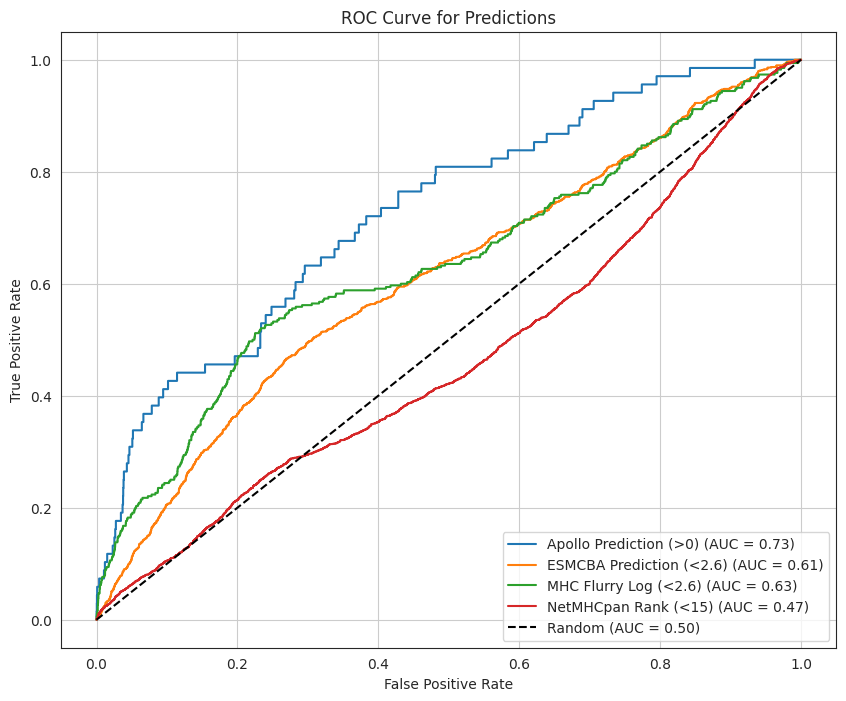

In [43]:
from sklearn.metrics import roc_curve, auc

# Define binary labels for each column based on your criteria
merged_dta['apollo_label'] = (merged_dta['mhc_pred_0'] > 0).astype(int)
merged_dta['prediction_label'] = (merged_dta['prediction'] < 2.6).astype(int)
merged_dta['mhc_log_y_label'] = (merged_dta['mhc_log_y'] < 2.6).astype(int)
merged_dta['BA_Rank_label'] = (merged_dta['BA_Rank'] < 15).astype(int)


# Predictors (use plddt_x as the predictor variable for all three models)
predictor = merged_dta['plddt_x']

# Plot ROC curves
plt.figure(figsize=(10, 8))

labels_and_names = [
    ('apollo_label', 'Apollo Prediction (>0)'),
    ('prediction_label', 'ESMCBA Prediction (<2.6)'),
    ('mhc_log_y_label', 'MHC Flurry Log (<2.6)'),
    ('BA_Rank_label', 'NetMHCpan Rank (<15)')
]

for label_col, name in labels_and_names:
    fpr, tpr, _ = roc_curve(merged_dta[label_col], predictor)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot random guess baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

# Labels and formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Predictions')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()




In [44]:
counts_epitopes = merged_dta.groupby('hla_allele_x').size().reset_index(name='counts')
counts_epitopes[counts_epitopes['counts'] > 2]

,hla_allele_x,counts
0,A0201,13352
1,A0206,2192
4,B1501,3939
5,B1801,2533
11,B5701,2032


In [45]:
num_sequences_test = 500

training_data = pd.DataFrame()

for formatted_HLA in ['A0201', 'B1501', 'B5701','B1801','A0206']:
    
    train_fasta = f"/global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLA{formatted_HLA}_final.csv"

    train_fasta = pd.read_csv(train_fasta, header=None)
    train_fasta.columns = ['sequence', 'ref_ID', 'submissionID', 'Epitope_ID', 'protein_origin', 
                        'ID_SOURCE', 'SOURCE_ORGANISM', 'IC50_nM', 'DESCRIPTION_BINDING', 'Year_submission']
    train_fasta['HLA'] = formatted_HLA
   #  train_fasta = train_fasta[['sequence','HLA']].head(num_sequences_test)
    training_data = pd.concat([training_data, train_fasta])


In [46]:
merged_dta[merged_dta['sequence'].isin(training_data['sequence'])].shape[0]

0

In [47]:
episcan_epitopes = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/41587_2022_1566_MOESM5_ESM 2.csv', header = 1)

# Keep only the columns of interest
df = episcan_epitopes[['A2 binders', 'B57 abacavir binders']]

# Map column names → proper allele names
allele_map = {
    'A2 binders':            'HLA-A*02:01',
    'B57 abacavir binders':  'HLA-B*57:01'
}

# ── Option 1: melt ───────────────────────────────────────────
long_df = (
    df.melt(value_vars=df.columns,          # the two binder columns
            var_name='HLA',                 # new column holding the column names
            value_name='sequence')          # new column holding the sequences
      .dropna(subset=['sequence'])          # remove rows where the sequence was NaN
      .replace({'HLA': allele_map})         # pretty allele names
      .reset_index(drop=True)
)

# ── Option 2: concat (explicit) ──────────────────────────────
alt_df = (
    pd.concat([
        df['A2 binders']
          .dropna()
          .rename('sequence')
          .to_frame()
          .assign(HLA='HLA-A*02:01'),

        df['B57 abacavir binders']
          .dropna()
          .rename('sequence')
          .to_frame()
          .assign(HLA='HLA-B*57:01')
    ])
    .reset_index(drop=True)
)


long_df

/tmp/ipykernel_2030438/608960220.py:1: DtypeWarning: Columns (1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  episcan_epitopes = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/41587_2022_1566_MOESM5_ESM 2.csv', header = 1)


,HLA,sequence
0,HLA-A*02:01,FVADYIASI
1,HLA-A*02:01,HIFEGVIGV
2,HLA-A*02:01,YICDESVPV
3,HLA-A*02:01,YLSDTIVSV
4,HLA-A*02:01,YLSDSFVPV
...,...,...
1025,HLA-B*57:01,SSISDHLRW
1026,HLA-B*57:01,GTHIDEYPW
1027,HLA-B*57:01,VSLPSDARW
1028,HLA-B*57:01,SSVGDRTGW


In [48]:
"""
pwm_distance.py
Compare peptide-binding motifs (PWMs) between *predicted* designs and *training* data,
and estimate the intrinsic variability of the training data via bootstrap splits.
"""

episcan_epitopes = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/41587_2022_1566_MOESM5_ESM 2.csv', header = 1)
episcan_epitopes

# ──────────────────────────────────────────────────────────────────────────────
# 0  Imports & global settings
# ──────────────────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.spatial.distance import euclidean
from scipy.stats import entropy                            # for Jensen–Shannon

AA = list("ACDEFGHIKLMNPQRSTVWY")   # 20-aa alphabet
PSEUDOCOUNT = 1                     # avoids log(0) and /0 problems
PEPTIDE_LEN = 9                     # change to 8, 10, 11… if needed
RNG_SEED     = 42                   # global reproducibility


# ──────────────────────────────────────────────────────────────────────────────
# 1  Core helper functions
# ──────────────────────────────────────────────────────────────────────────────
def build_pwm(df: pd.DataFrame,
              seq_col: str,
              allele_col: str,
              length: int = PEPTIDE_LEN,
              pseudocount: int = PSEUDOCOUNT):
    """
    Return {allele: (L, 20) numpy array} where rows = positions,
    columns = AA probabilities.
    Only sequences of exact 'length' are used.
    """
    pwm = {}
    for hla, grp in df[df[seq_col].str.len() == length].groupby(allele_col):
        counts = np.zeros((length, 20))
        for seq in grp[seq_col]:
            for i, aa in enumerate(seq):
                if aa in AA:
                    counts[i, AA.index(aa)] += 1
        counts += pseudocount
        pwm[hla] = counts / counts.sum(axis=1, keepdims=True)
    return pwm


def jensen_shannon(p: np.ndarray, q: np.ndarray, base: int = 2) -> float:
    """
    Symmetric JS divergence (0 = identical, ≤ log2 bits).
    Expects *probability* vectors of equal length.
    """
    m = 0.5 * (p + q)
    return 0.5 * entropy(p, m, base=base) + 0.5 * entropy(q, m, base=base)


def split_per_allele(df: pd.DataFrame,
                     allele_col: str,
                     frac: float = 0.5,
                     seed: int = RNG_SEED):
    """
    Return two dataframes (A, B) where each HLA allele’s rows are randomly
    split in the same proportion 'frac'.
    """
    rng = np.random.default_rng(seed)
    partA, partB = [], []

    for hla, grp in df.groupby(allele_col):
        idx = grp.index.to_numpy()
        rng.shuffle(idx)
        cut = int(len(idx) * frac)
        partA.append(grp.loc[idx[:cut]])
        partB.append(grp.loc[idx[cut:]])

    return pd.concat(partA), pd.concat(partB)


def compute_distances(pwm1: dict, pwm2: dict):
    """
    Compare PWMs allele-wise; return tidy DataFrame with JS and L2.
    """
    rows = []
    for hla in set(pwm1) & set(pwm2):
        p = pwm1[hla].flatten()
        q = pwm2[hla].flatten()
        rows.append({
            "HLA": hla,
            "JS_bits": jensen_shannon(p, q),
            "L2": euclidean(p, q)
        })
    return pd.DataFrame(rows)


def bootstrap_baseline(df: pd.DataFrame,
                       seq_col: str,
                       allele_col: str,
                       n_iter: int = 100,
                       length: int = PEPTIDE_LEN):
    """
    Re-sample training data 'n_iter' times, splitting each time;
    returns DataFrame with JS divergence per iteration & allele.
    """
    out = defaultdict(list)
    for i in range(n_iter):
        A, B = split_per_allele(df, allele_col, seed=i)
        pwm_A = build_pwm(A, seq_col, allele_col, length)
        pwm_B = build_pwm(B, seq_col, allele_col, length)
        for hla in set(pwm_A) & set(pwm_B):
            out["iter"].append(i)
            out["HLA"].append(hla)
            out["JS_bits"].append(jensen_shannon(
                pwm_A[hla].flatten(),
                pwm_B[hla].flatten()))
    return pd.DataFrame(out)


/tmp/ipykernel_2030438/643196982.py:7: DtypeWarning: Columns (1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  episcan_epitopes = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/41587_2022_1566_MOESM5_ESM 2.csv', header = 1)


In [49]:
long_df['HLA'] = long_df['HLA'].str.replace('HLA-', '').str.replace(':', '').str.replace('*', '')

In [50]:
training_data = training_data[training_data['IC50_nM'] != '\\N']
training_data['IC50_nM'] = training_data['IC50_nM'].astype(float)
training_data_highba = training_data[training_data['IC50_nM'] < 500]

In [51]:
# pd.set_option('display.max_rows', None) # change to only 10 
pd.set_option('display.max_columns', None) # change to only 10
#reset rows pandas 
pd.reset_option('display.max_rows')

In [52]:
# ──────────────────────────────────────────────────────────────
# 2  BUILD PWMs
# ──────────────────────────────────────────────────────────────
pwm_pred     = build_pwm(merged_dt[merged_dt['plddt_x'] > 0.6],
                         seq_col="sequence",  allele_col="hla_allele_x")
pwm_train    = build_pwm(training_data_highba,      seq_col="sequence", allele_col="HLA")
pwm_episcan  = build_pwm(long_df,   seq_col="sequence", allele_col="HLA")

# ──────────────────────────────────────────────────────────────
# 3  PAIRWISE DISTANCES
# ──────────────────────────────────────────────────────────────
# 3-A  Predicted vs Training
dist_pred_vs_train = (compute_distances(pwm_pred, pwm_train)
                      .rename(columns={"JS_bits": "JS_pred_vs_train",
                                       "L2":      "L2_pred_vs_train"}))

# 3-B  EpiScan vs Training
dist_epi_vs_train  = (compute_distances(pwm_episcan, pwm_train)
                      .rename(columns={"JS_bits": "JS_epi_vs_train",
                                       "L2":      "L2_epi_vs_train"}))

# 3-C  EpiScan vs Predicted
dist_epi_vs_pred   = (compute_distances(pwm_episcan, pwm_pred)
                      .rename(columns={"JS_bits": "JS_epi_vs_pred",
                                       "L2":      "L2_epi_vs_pred"}))

# ──────────────────────────────────────────────────────────────
# 4  TRAINING-SET NOISE FLOORS
# ──────────────────────────────────────────────────────────────
# 4-A  One 50/50 split
A, B = split_per_allele(training_data, allele_col="HLA")
baseline_split = (compute_distances(build_pwm(A, "sequence", "HLA"),
                                    build_pwm(B, "sequence", "HLA"))
                  .rename(columns={"JS_bits": "JS_split",
                                   "L2":      "L2_split"}))

# 4-B  Bootstrap median of 100 splits
boot   = bootstrap_baseline(training_data, "sequence", "HLA", n_iter=100)
median_boot = (boot.groupby("HLA")["JS_bits"].median()
               .reset_index()
               .rename(columns={"JS_bits": "JS_boot"}))

# ──────────────────────────────────────────────────────────────
# 5  MERGE EVERYTHING (JS ONLY ― swap to L2 if you prefer)
# ──────────────────────────────────────────────────────────────
js_table = (dist_pred_vs_train[["HLA", "JS_pred_vs_train"]]
            .merge(dist_epi_vs_train[["HLA", "JS_epi_vs_train"]], on="HLA")
            .merge(dist_epi_vs_pred[["HLA", "JS_epi_vs_pred"]],   on="HLA")
            .merge(baseline_split[["HLA", "JS_split"]],           on="HLA")
            .merge(median_boot,                                   on="HLA"))

print("★  All JS distances in one table")
print(js_table.head())

# ──────────────────────────────────────────────────────────────
# 6  LONG (TIDY) FORMAT FOR SEABORN PLOT
# ──────────────────────────────────────────────────────────────
df_plot = js_table.melt(id_vars="HLA",
                        var_name="Source",
                        value_name="JS")

# Optional: order alleles by predicted JS for readability
allele_order = (js_table.sort_values("JS_pred_vs_train",
                                     ascending=False)["HLA"])
df_plot["HLA"] = pd.Categorical(df_plot["HLA"],
                                categories=allele_order,
                                ordered=True)

★  All JS distances in one table
     HLA  JS_pred_vs_train  JS_epi_vs_train  JS_epi_vs_pred  JS_split  \
0  A0201          0.229043         0.083899        0.291287  0.010897   
1  B5701          0.198854         0.072184        0.206039  0.010934   

    JS_boot  
0  0.010897  
1  0.010934  


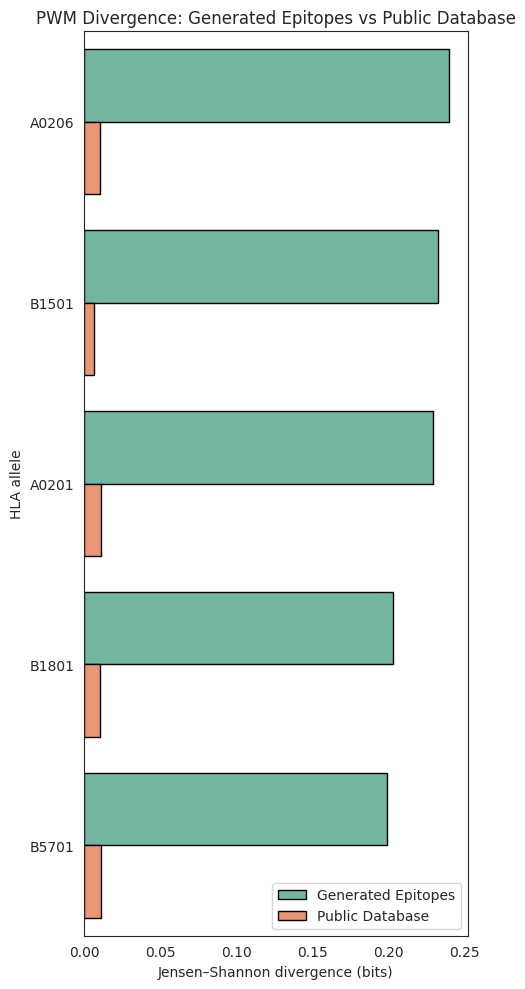

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────────────────────
# 1. Merge JS scores from predictions and baseline
# ──────────────────────────────────────────────────────────────
js_table = (
    dist_pred_vs_train[["HLA", "JS_pred_vs_train"]]
    .merge(baseline_split[["HLA", "JS_split"]], on="HLA")
)

# ──────────────────────────────────────────────────────────────
# 2. Convert to long format and relabel
# ──────────────────────────────────────────────────────────────
df_plot = (
    js_table.melt(id_vars="HLA", var_name="Source", value_name="JS")
    .replace({"Source": {
        "JS_pred_vs_train": "Generated Epitopes",
        "JS_split": "Public Database"
    }})
)

# Optional: order alleles by JS_pred_vs_train
allele_order = js_table.sort_values("JS_pred_vs_train", ascending=False)["HLA"]
df_plot["HLA"] = pd.Categorical(df_plot["HLA"], categories=allele_order, ordered=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 10))  # Taller figure for vertical HLA labels

sns.barplot(
    data=df_plot,
    y="HLA",          # HLA on the y-axis now
    x="JS",           # JS on the x-axis
    hue="Source",
    palette="Set2",
    edgecolor="black"
)

plt.xlabel("Jensen–Shannon divergence (bits)")
plt.ylabel("HLA allele")
plt.title("PWM Divergence: Generated Epitopes vs Public Database")
plt.legend(title="")
plt.tight_layout()
plt.show()



In [54]:

# # ──────────────────────────────────────────────────────────────
# # 7  GROUPED BAR-PLOT
# # ──────────────────────────────────────────────────────────────
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))
# sns.barplot(data=df_plot,
#             x="HLA", y="JS", hue="Source",
#             palette="Set2", edgecolor="black")

# plt.ylabel("Jensen–Shannon divergence (bits)")
# plt.xlabel("HLA allele")
# plt.title("PWM divergence: Predicted, EpiScan & training baselines")
# plt.xticks(rotation=45)
# plt.legend(title="")
# plt.tight_layout()
# plt.show()


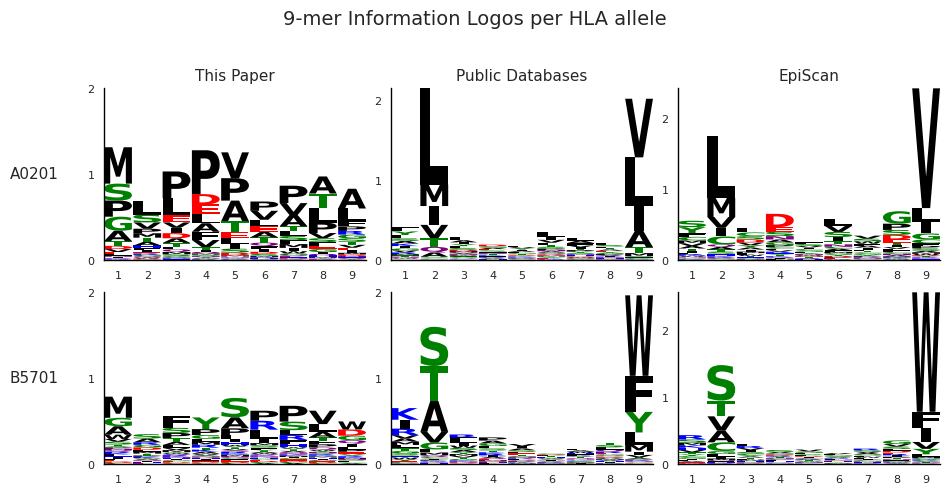

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logomaker

# -----------------------------------------------------------------------------
#  Assumes pwm_pred, pwm_train, pwm_episcan already exist in memory
#  and were built for 9‑mers.
# -----------------------------------------------------------------------------
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
bg_probs    = [1/20] * 20                # uniform background

datasets = {
    "This Paper": pwm_pred,
    "Public Databases":  pwm_train,
    "EpiScan":   pwm_episcan,
}

# only alleles present in every dataset
common_hlas = sorted(set.intersection(*(set(d) for d in datasets.values())))

if not common_hlas:
    raise ValueError("No common HLA alleles across all three datasets.")

n_rows = len(common_hlas)
n_cols = len(datasets)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 3.2, n_rows * 2.4),
    squeeze=False
)

for r, hla in enumerate(common_hlas):
    for c, (src_name, pwm_dict) in enumerate(datasets.items()):
        ax = axes[r][c]
        pwm = pwm_dict[hla]             # shape (9, 20) frequencies
        freq_df = pd.DataFrame(pwm, columns=amino_acids)

        # convert to information content (bits above uniform)
        info_df = logomaker.transform_matrix(
            freq_df,
            from_type="probability",
            to_type="information",
            background=bg_probs
        )

        logo = logomaker.Logo(
            info_df,
            ax=ax,
            color_scheme="chemistry"
        )
        logo.style_spines(visible=False)
        logo.style_spines(spines=['left', 'bottom'], visible=True)

        ax.set_xticks(range(pwm.shape[0]))
        ax.set_xticklabels([str(i + 1) for i in range(pwm.shape[0])], fontsize=8)
        ax.set_ylabel("")

        # Column headers
        if r == 0:
            ax.set_title(src_name, fontsize=11, pad=6)

        # Row labels
        if c == 0:
            ax.set_ylabel(hla, rotation=0, fontsize=11,
                          labelpad=38, va="center")

        # Clean y‑axis ticks
        ax.set_yticks([0, 1, 2])
        ax.set_yticklabels(["0", "1", "2"], fontsize=8)

plt.suptitle("9‑mer Information Logos per HLA allele", fontsize=14, y=1.02)
plt.tight_layout(h_pad=0.6, w_pad=0.6)
plt.show()


In [56]:
# fwefew

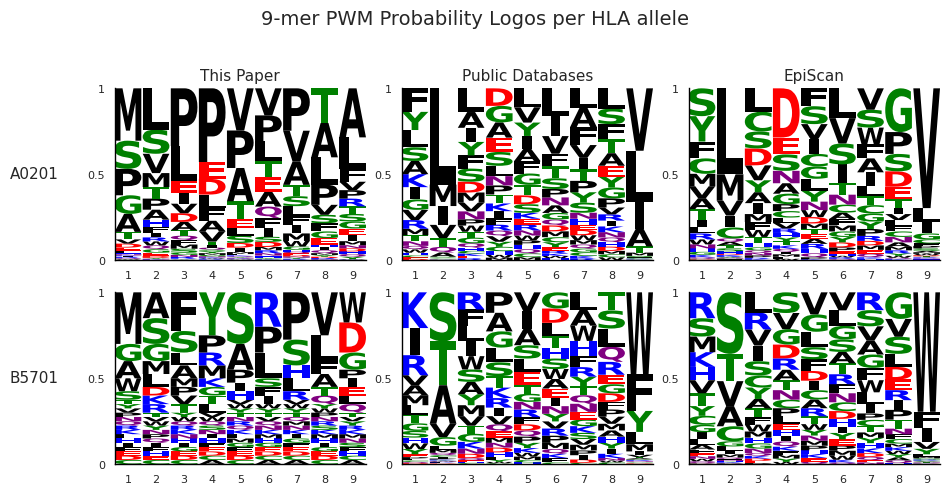

In [57]:
# -----------------------------------------------------------------------------
#  Assumes pwm_pred, pwm_train, pwm_episcan already exist in memory (9-mer PWM).
# -----------------------------------------------------------------------------
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

pwm_pred     = build_pwm(merged_dt[merged_dt['plddt_x'] > 0.65],
                         seq_col="sequence",  allele_col="hla_allele_x")
pwm_train    = build_pwm(training_data_highba,      seq_col="sequence", allele_col="HLA")
pwm_episcan  = build_pwm(long_df,   seq_col="sequence", allele_col="HLA")


datasets = {
    "This Paper":        pwm_pred,
    "Public Databases":  pwm_train,
    "EpiScan":           pwm_episcan,
}

# alleles common to every dataset
common_hlas = sorted(set.intersection(*(set(d) for d in datasets.values())))

if not common_hlas:
    raise ValueError("No common HLA alleles across the three datasets.")

n_rows = len(common_hlas)
n_cols = len(datasets)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 3.2, n_rows * 2.4),
    squeeze=False
)

for r, hla in enumerate(common_hlas):
    for c, (src_name, pwm_dict) in enumerate(datasets.items()):
        ax = axes[r][c]
        pwm = pwm_dict[hla]                    # (9, 20) position × AA probs
        freq_df = pd.DataFrame(pwm, columns=amino_acids)

        # ── draw *probability* logo (no background enrichment) ─────────────
        logo = logomaker.Logo(
            freq_df,
            ax=ax,
            color_scheme="chemistry"
        )
        logo.style_spines(visible=False)
        logo.style_spines(spines=['left', 'bottom'], visible=True)

        # X‑axis setup
        ax.set_xticks(range(pwm.shape[0]))
        ax.set_xticklabels([str(i + 1) for i in range(pwm.shape[0])], fontsize=8)

        # Y‑axis setup
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 0.5, 1.0])
        ax.set_yticklabels(["0", "0.5", "1"], fontsize=8)
        ax.set_ylabel("")

        # Column titles
        if r == 0:
            ax.set_title(src_name, fontsize=11, pad=6)

        # Row labels
        if c == 0:
            ax.set_ylabel(hla, rotation=0, fontsize=11,
                          labelpad=38, va="center")

plt.suptitle("9‑mer PWM Probability Logos per HLA allele", fontsize=14, y=1.02)
plt.tight_layout(h_pad=0.6, w_pad=0.6)
plt.show()


In [82]:
espican = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/EPISCAN_A0201_sourcedata6.tsv', sep ='\t')
espican['HLA'] = 'A0201'
espican.head()

/tmp/ipykernel_2030438/3493180940.py:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  espican = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/EPISCAN_A0201_sourcedata6.tsv', sep ='\t')


,Decoys,Binders - low threshold,Binders - high threshold,Unnamed: 3,Unnamed: 4,HLA
0,EEEQEEHQK,YTETALDEI,NIIDELPPC,NaN,NaN,A0201
1,GSRTPKRSR,ILNGTPLYM,LQCNVFPGL,NaN,NaN,A0201
2,EGRTLDAKM,SSTSTSIKV,SSCSVLLTV,NaN,NaN,A0201
3,NFEQQPDSR,YVCTATNTV,ILLVEVPDI,NaN,NaN,A0201
4,NKSMTFDHR,RCLAALTEC,LQDQTLIAV,NaN,NaN,A0201


In [83]:
epsican_b5701 = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/EPISCAN_B5701_sourcedata6.tsv', sep = '\t')
epsican_b5701['HLA'] = 'B5701'
epsican_b5701.head()

/tmp/ipykernel_2030438/2752445428.py:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  epsican_b5701 = pd.read_csv('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/jupyter_notebooks/rdfiffusion/EPISCAN_B5701_sourcedata6.tsv', sep = '\t')


,Decoys,Binders - low threshold,Binders - high threshold,Unnamed: 3,Unnamed: 4,HLA
0,GRDMLPGED,NTMNITISK,TSIVHLFEW,NaN,NaN,B5701
1,NYPATLTPS,AVTVSMGLW,MAAPSAGSW,NaN,NaN,B5701
2,DRVYGGLTT,HAHELMLKY,KIINANMTW,NaN,NaN,B5701
3,PRRYHVSVH,TSIVHLFEW,KAGLPLGAW,NaN,NaN,B5701
4,QRSHLLIHQ,MAAPSAGSW,KLQNLVIPW,NaN,NaN,B5701


In [86]:
episcan_full = pd.concat([epsican_b5701, espican])

In [88]:
pwm_episcan  = build_pwm(episcan_full,   seq_col="Binders - high threshold", allele_col="HLA")


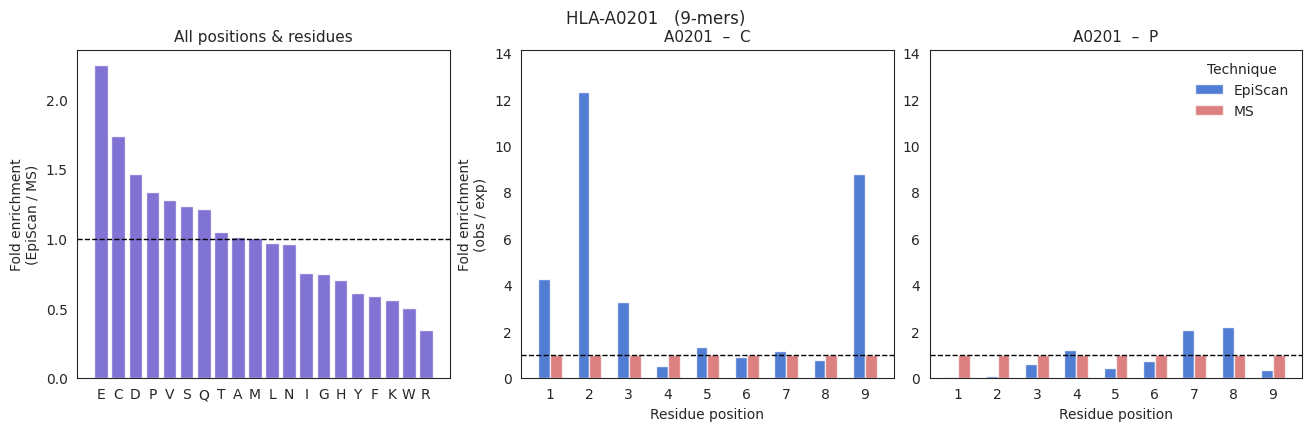

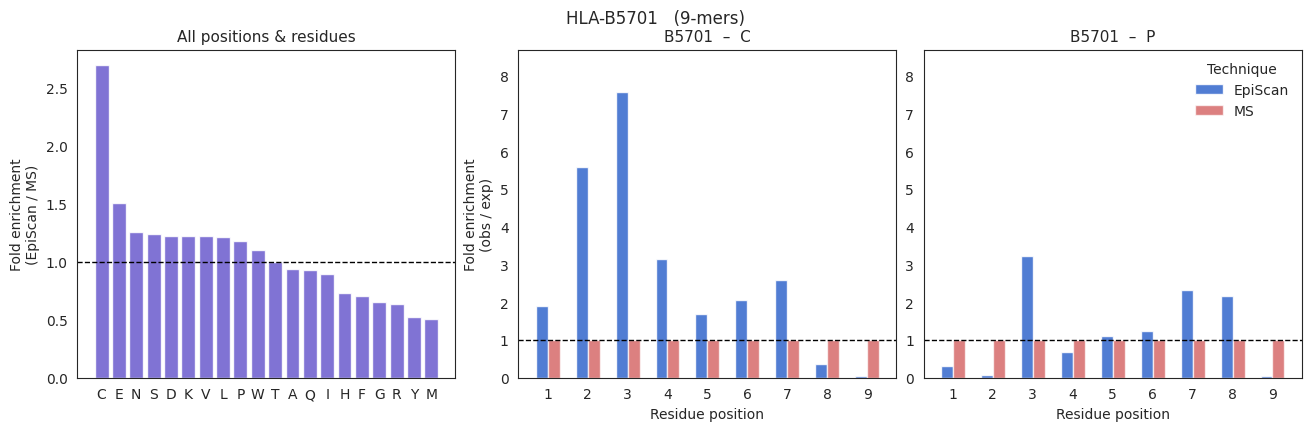

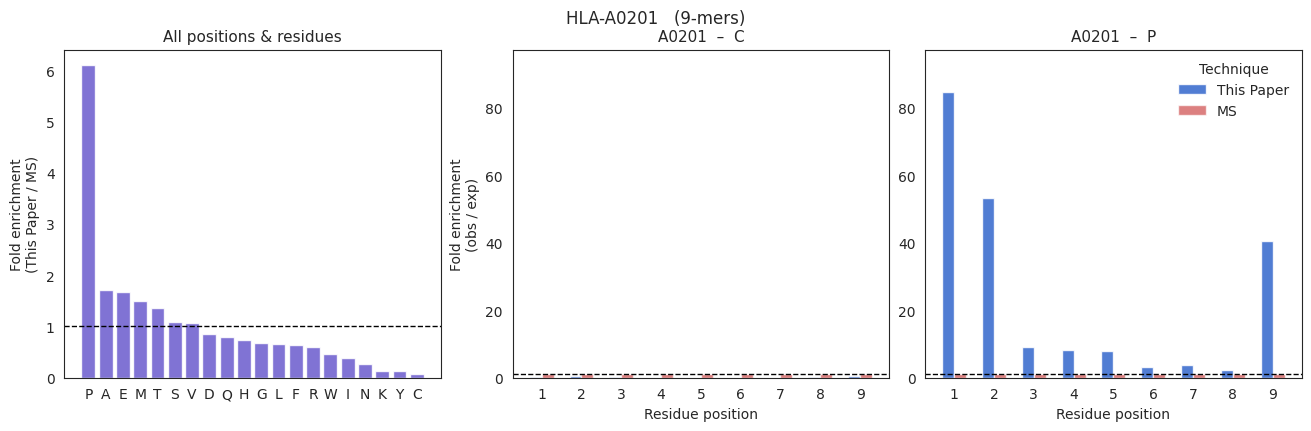

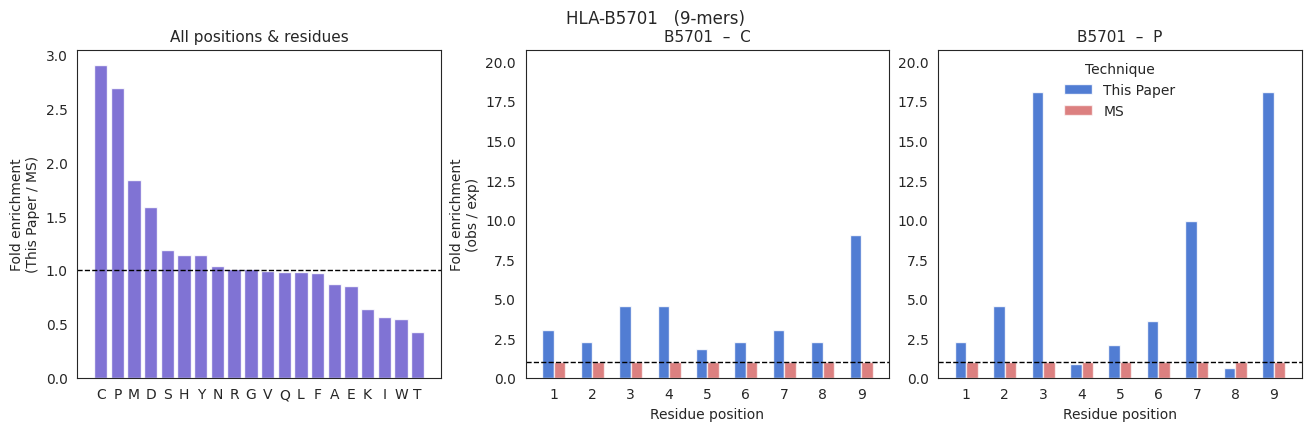

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

AA = list("ACDEFGHIKLMNPQRSTVWY")   # 20 aa
L  = 9                              # 9-mers only
bar_alpha = .85
col_epi, col_ms = "#3366cc", "#cc4444"   # blue / red for panels 2–3

def pwm_to_counts(pwm, total_n):
    """Convert (L,20) probability PWM back to raw counts."""
    return pwm * total_n

def per_pos_fold(cnt_epi, cnt_ms, residue):
    idx = AA.index(residue)
    p_epi = cnt_epi[:, idx] / cnt_epi.sum()     # per-position frequency
    p_ms  = cnt_ms [:, idx] / cnt_ms .sum()
    return p_epi / p_ms                         # shape (L,)

def plot_enrichment(allele, focus=("C", "P"), pwm_train=None, pwm_episcan=None, label=None):
    # total peptide counts (≈ integer) for the PWM
    n_epi = int(round(pwm_episcan[allele].sum()))
    n_ms  = int(round(pwm_train  [allele].sum()))

    cnt_epi = pwm_to_counts(pwm_episcan[allele], n_epi)
    cnt_ms  = pwm_to_counts(pwm_train  [allele], n_ms)

    # panel 1 – global fold enrichment (EpiScan / MS) for each aa
    glob_fold = (cnt_epi.sum(axis=0)/n_epi) / (cnt_ms.sum(axis=0)/n_ms)
    aa_sorted = [aa for _, aa in sorted(zip(glob_fold, AA), reverse=True)]
    glob_sorted = np.sort(glob_fold)[::-1]

    # panel 2/3 – per-position fold for chosen residues
    fold_res1 = per_pos_fold(cnt_epi, cnt_ms, focus[0])
    fold_res2 = per_pos_fold(cnt_epi, cnt_ms, focus[1])

    # ── plotting ────────────────────────────────────────────────
    fig, ax = plt.subplots(1, 3, figsize=(13, 4), constrained_layout=True)

    # ① global
    ax[0].bar(aa_sorted, glob_sorted, color="#6a5acd", alpha=bar_alpha)
    ax[0].axhline(1, ls="--", c="k", lw=1)
    ax[0].set_ylabel(f"Fold enrichment\n({label} / MS)")
    ax[0].set_title("All positions & residues", fontsize=11)

    # share Y-axis scale for bar clarity
    ymax = max(glob_sorted.max(),
               fold_res1.max(),
               fold_res2.max()) * 1.15

    # ② first residue
    pos = np.arange(1, L+1)
    ax[1].bar(pos-0.15, fold_res1, width=.3,
              label=label, color=col_epi, alpha=bar_alpha)
    ax[1].bar(pos+0.15, np.ones(L), width=.3,
              label="MS", color=col_ms, alpha=bar_alpha*.8)
    ax[1].set_ylim(0, ymax)
    ax[1].axhline(1, ls="--", c="k", lw=1)
    ax[1].set_xticks(pos)
    ax[1].set_xlabel("Residue position")
    ax[1].set_ylabel("Fold enrichment\n(obs / exp)")
    ax[1].set_title(f"{allele}  –  {focus[0]}", fontsize=11)

    # ③ second residue
    ax[2].bar(pos-0.15, fold_res2, width=.3,
              label=label, color=col_epi, alpha=bar_alpha)
    ax[2].bar(pos+0.15, np.ones(L), width=.3,
              label="MS", color=col_ms, alpha=bar_alpha*.8)
    ax[2].set_ylim(0, ymax)
    ax[2].axhline(1, ls="--", c="k", lw=1)
    ax[2].set_xticks(pos)
    ax[2].set_xlabel("Residue position")
    ax[2].set_title(f"{allele}  –  {focus[1]}", fontsize=11)
    ax[2].legend(title="Technique", frameon=False)

    # figure-level title
    fig.suptitle(f"HLA-{allele.replace(':','*')}   (9-mers)",
                 y=1.04, fontsize=12)

    plt.show()

# ───────── call for the two requested alleles ─────────────────
for allele in ["A0201", "B5701"]:       # swap to B5701 if that’s the allele key
    plot_enrichment(allele, focus=("C", "P"),pwm_train=pwm_train, pwm_episcan=pwm_episcan, label="EpiScan")

# ───────── call for the two requested alleles ─────────────────
for allele in ["A0201", "B5701"]:       # swap to B5701 if that’s the allele key
    plot_enrichment(allele, focus=("C", "P"),pwm_train=pwm_train, pwm_episcan=pwm_pred, label="This Paper")


In [59]:
# ---------- helper functions ----------
def pwm_to_counts(pwm, n_peptides):
    """Convert probability PWM to integer-like counts."""
    return pwm * float(n_peptides)

def per_pos_enrichment(counts, residue, alpha=0.5):
    """
    For one residue, return a length-L vector of
        (observed freq at pos i) / (global freq)   with pseudocount smoothing.
    """
    idx = AA.index(residue)           # column of the residue
    L, _ = counts.shape

    # total counts per position and globally (with alpha smoothing)
    pos_tot = counts.sum(axis=1) + alpha * len(AA)
    glob_tot = counts.sum() + alpha * len(AA) * L

    # observed & expected probability
    obs = (counts[:, idx] + alpha) / pos_tot          # shape (L,)
    exp = (counts[:, idx].sum() + alpha) / glob_tot   # scalar

    return obs / exp                                  # shape (L,)

# ---------- main plotting function ----------
def plot_enrichment(
        allele,
        focus=("C", "P"),
        pwm_train=None,
        pwm_episcan=None,
        label_epi="EpiScan",
        label_ms ="MS"
    ):
    # total peptide counts (you should pass the *real* N if you have it)
    n_epi = round(pwm_episcan[allele].sum())
    n_ms  = round(pwm_train  [allele].sum())

    cnt_epi = pwm_to_counts(pwm_episcan[allele], n_epi)
    cnt_ms  = pwm_to_counts(pwm_train  [allele], n_ms)

    # ── global enrichment panel ────────────────────────────────
    freq_epi = cnt_epi.sum(axis=0) / cnt_epi.sum()
    freq_ms  = cnt_ms .sum(axis=0) / cnt_ms .sum()
    glob_fold = freq_epi / freq_ms

    aa_sorted = [aa for _, aa in sorted(zip(glob_fold, AA), reverse=True)]
    glob_sorted = np.sort(glob_fold)[::-1]

    # ── per-position enrichment for the two chosen residues ────
    fold_epi_1 = per_pos_enrichment(cnt_epi, focus[0])
    fold_ms_1  = per_pos_enrichment(cnt_ms , focus[0])

    fold_epi_2 = per_pos_enrichment(cnt_epi, focus[1])
    fold_ms_2  = per_pos_enrichment(cnt_ms , focus[1])

    # ── plotting ───────────────────────────────────────────────
    fig, ax = plt.subplots(1, 3, figsize=(13, 4), constrained_layout=True)

    # ① global enrichment
    ax[0].bar(aa_sorted, glob_sorted, color="#6a5acd", alpha=0.85)
    ax[0].axhline(1, ls="--", c="k", lw=1)
    ax[0].set_ylabel(f"Fold enrichment\n({label_epi} / {label_ms})")
    ax[0].set_title("All positions & residues", fontsize=11)

    # common Y limit for clarity
    ymax = max(
        glob_sorted.max(),
        fold_epi_1.max(), fold_ms_1.max(),
        fold_epi_2.max(), fold_ms_2.max()
    ) * 1.15

    pos = np.arange(1, L + 1)

    # ② first residue
    ax[1].bar(pos - 0.18, fold_epi_1, width=0.35,
              label=label_epi, color="#3366cc", alpha=0.85)
    ax[1].bar(pos + 0.18, fold_ms_1 , width=0.35,
              label=label_ms , color="#cc4444", alpha=0.75)
    ax[1].set_ylim(0, ymax)
    ax[1].axhline(1, ls="--", c="k", lw=1)
    ax[1].set_xticks(pos)
    ax[1].set_xlabel("Residue position")
    ax[1].set_ylabel("Fold enrichment\n(obs / exp)")
    ax[1].set_title(f"{allele}  –  {focus[0]}", fontsize=11)

    # ③ second residue
    ax[2].bar(pos - 0.18, fold_epi_2, width=0.35,
              label=label_epi, color="#3366cc", alpha=0.85)
    ax[2].bar(pos + 0.18, fold_ms_2 , width=0.35,
              label=label_ms , color="#cc4444", alpha=0.75)
    ax[2].set_ylim(0, ymax)
    ax[2].axhline(1, ls="--", c="k", lw=1)
    ax[2].set_xticks(pos)
    ax[2].set_xlabel("Residue position")
    ax[2].set_title(f"{allele}  –  {focus[1]}", fontsize=11)
    ax[2].legend(title="Technique", frameon=False)

    fig.suptitle(f"HLA-{allele.replace(':','*')}   ({L}-mers)",
                 y=1.04, fontsize=12)
    plt.show()


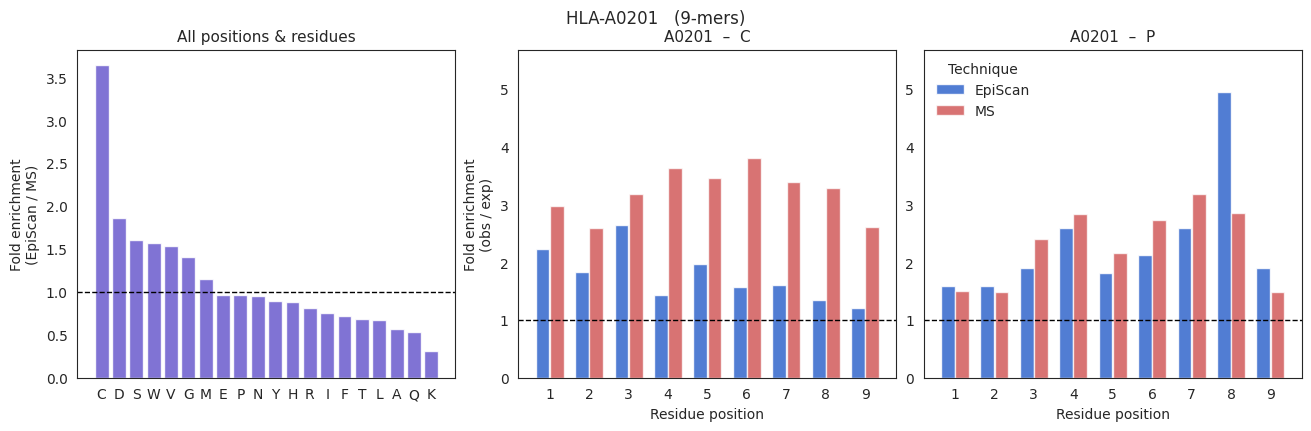

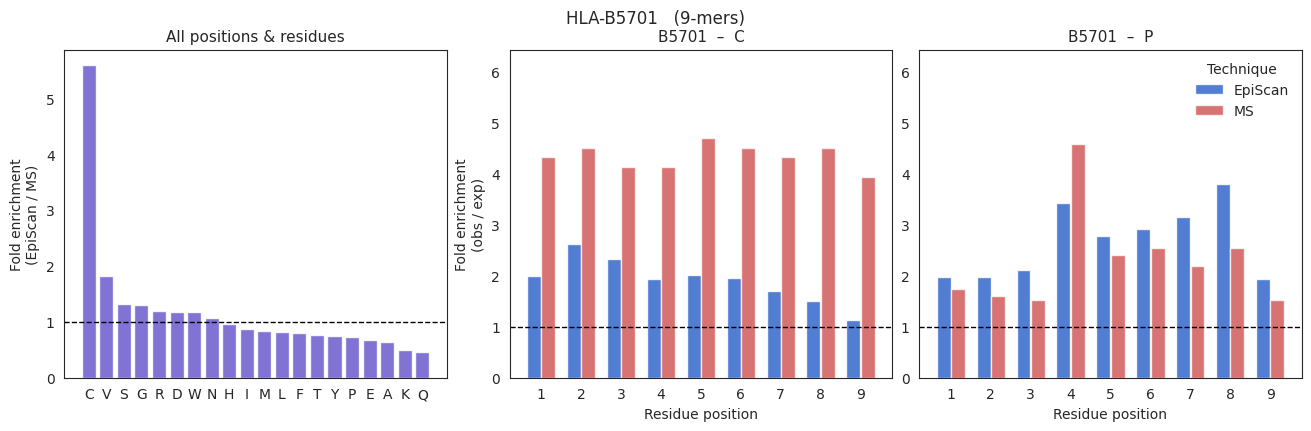

In [60]:
for allele in ["A0201", "B5701"]:
    plot_enrichment(
        allele,
        focus=("C", "P"),
        pwm_train=pwm_train,
        pwm_episcan=pwm_episcan
    )


In [61]:
fwefewfew

NameError: name 'fwefewfew' is not defined

/clusterfs/nilah/sergio/miniconda3/envs/ESM_cambrian/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/clusterfs/nilah/sergio/miniconda3/envs/ESM_cambrian/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/clusterfs/nilah/sergio/miniconda3/envs/ESM_cambrian/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/clusterfs/nilah/sergio/miniconda3/envs/ESM_cambrian/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.

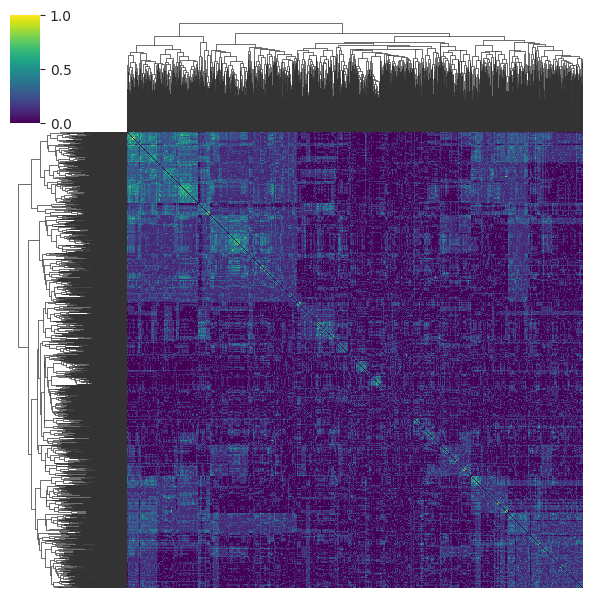

In [ ]:
#### Q8 ─ How diverse are designs among themselves? (pairwise-identity heatmap)

from itertools import combinations
def pairwise_identity(seq_list):
    n=len(seq_list)
    pid=np.zeros((n,n))
    for (i,s1),(j,s2) in combinations(enumerate(seq_list),2):
        pid[i,j]=pid[j,i]=sum(a==b for a,b in zip(s1,s2))/len(s1)
    return pid
    
sample = merged_dt[merged_dt['plddt_x'] > 0.6].sequence.tolist()
pid    = pairwise_identity(sample)
sns.clustermap(pid, cmap="viridis", figsize=(6,6), xticklabels=False, yticklabels=False)
# plt.title("Pairwise identity – 500 RFdiffusion peptides"); 
plt.show()

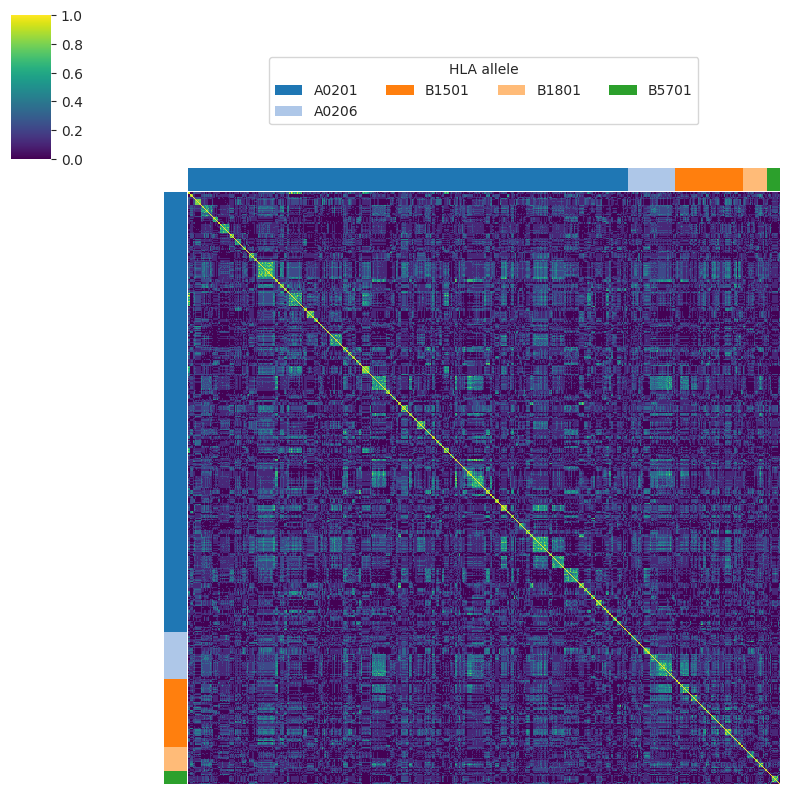

In [ ]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from itertools import combinations

# ──────────────────────────────────────────────────────────────────────────────
# 0.  Filter designs
# ──────────────────────────────────────────────────────────────────────────────
filtered = merged_dt[
    (merged_dt['plddt_x'] > 0.6) &
    (merged_dt['hla_allele_x'].isin(['A0201', 'A0206', 'B5701', 'B1801', 'B2705', 'B1501'])) &
    (merged_dt['sequence'].apply(len) == 9) 
]

subset   = filtered[['sequence', 'hla_allele_x']].reset_index(drop=True)

# sanity-check: all sequences same length?
lengths = subset['sequence'].str.len().unique()
if len(lengths) != 1:
    raise ValueError(f"Sequences have different lengths: {lengths}")

seqs    = subset['sequence'].tolist()
alleles = subset['hla_allele_x']              # index-matched to seqs

# ──────────────────────────────────────────────────────────────────────────────
# 1.  Fast pairwise-identity matrix  (vectorised, no Python loops 😊)
# ──────────────────────────────────────────────────────────────────────────────
L   = lengths[0]
arr = np.frombuffer(''.join(seqs).encode('ascii'), dtype='S1').reshape(len(seqs), L)
pid = (arr[:, None, :] == arr[None, :, :]).mean(axis=2)   # N×N matrix of identities

# ──────────────────────────────────────────────────────────────────────────────
# 2.  (Optional) order sequences so alleles appear in blocks
# ──────────────────────────────────────────────────────────────────────────────
order = alleles.argsort(kind='mergesort')                 # stable sort
pid   = pid[np.ix_(order, order)]
alleles = alleles.iloc[order].reset_index(drop=True)

# ──────────────────────────────────────────────────────────────────────────────
# 3. Colour map ───────────────────────────────────────────────────────────────
palette  = sns.color_palette('tab20', alleles.nunique())
lut      = dict(zip(sorted(alleles.unique()), palette))

row_cols = alleles.map(lut).to_numpy()   # ← convert Series → NumPy array
col_cols = row_cols                      # symmetric matrix

# 4. Plot ─────────────────────────────────────────────────────────────────────
g = sns.clustermap(
        pid,
        cmap='viridis',
        row_colors=row_cols,
        col_colors=col_cols,
        figsize=(8, 8),
        xticklabels=False,
        yticklabels=False,
        row_cluster=False,
        col_cluster=False,
)


# Legend
for allele, colour in lut.items():
    g.ax_col_dendrogram.bar(0, 0, color=colour, label=allele, linewidth=0)
g.ax_col_dendrogram.legend(loc='center', ncol=4, title='HLA allele')

plt.show()



In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy

AA = list("ACDEFGHIKLMNPQRSTVWY")   # 20 aa
L  = 9                              # 9-mer PWMs
pseudocount = 1e-3                  # smooth zeros for JS

# ──────────────────────────────────────────────────────────────
# 1.  Collect sequences ≥0.6 pLDDT, group by PDB
# ──────────────────────────────────────────────────────────────
mask = merged_dt['plddt_x'] > 0.6
grouper = merged_dt.loc[mask].groupby('pdb_id')

pwm_dict = {}          # {PDB → (9,20) matrix}

for pdb, grp in grouper:
    # keep only 9-mer peptides
    peptides = [s for s in grp['sequence'] if len(s) == L]
    if len(peptides) < 5:          # skip tiny sets (optional)
        continue

    counts = np.full((L, 20), pseudocount)        # init with pseudocount
    for seq in peptides:
        for i, aa in enumerate(seq):
            try:
                j = AA.index(aa)
                counts[i, j] += 1
            except ValueError:
                pass
    pwm_dict[pdb] = counts / counts.sum(axis=1, keepdims=True)

# ──────────────────────────────────────────────────────────────
# 2.  Build a flat DataFrame: rows = PDB, columns = 180 probs
# ──────────────────────────────────────────────────────────────
flat_pwm = pd.DataFrame({
    pdb: pwm.reshape(-1) for pdb, pwm in pwm_dict.items()
}).T    # transpose → PDBs as index

# ensure rows sum to L (should be 9)
assert np.allclose(flat_pwm.sum(axis=1), L, atol=1e-6)

# ──────────────────────────────────────────────────────────────
# 3.  Pairwise Jensen–Shannon divergence matrix
# ──────────────────────────────────────────────────────────────
def js_prob(p, q, base=2):
    m = 0.5 * (p + q)
    return 0.5 * entropy(p, m, base=base) + 0.5 * entropy(q, m, base=base)

pwm_js = pd.DataFrame(
    squareform(pdist(flat_pwm.values, metric=js_prob)),
    index=flat_pwm.index, columns=flat_pwm.index
)

print(f"JS matrix built for {pwm_js.shape[0]} PDBs.")


JS matrix built for 10 PDBs.


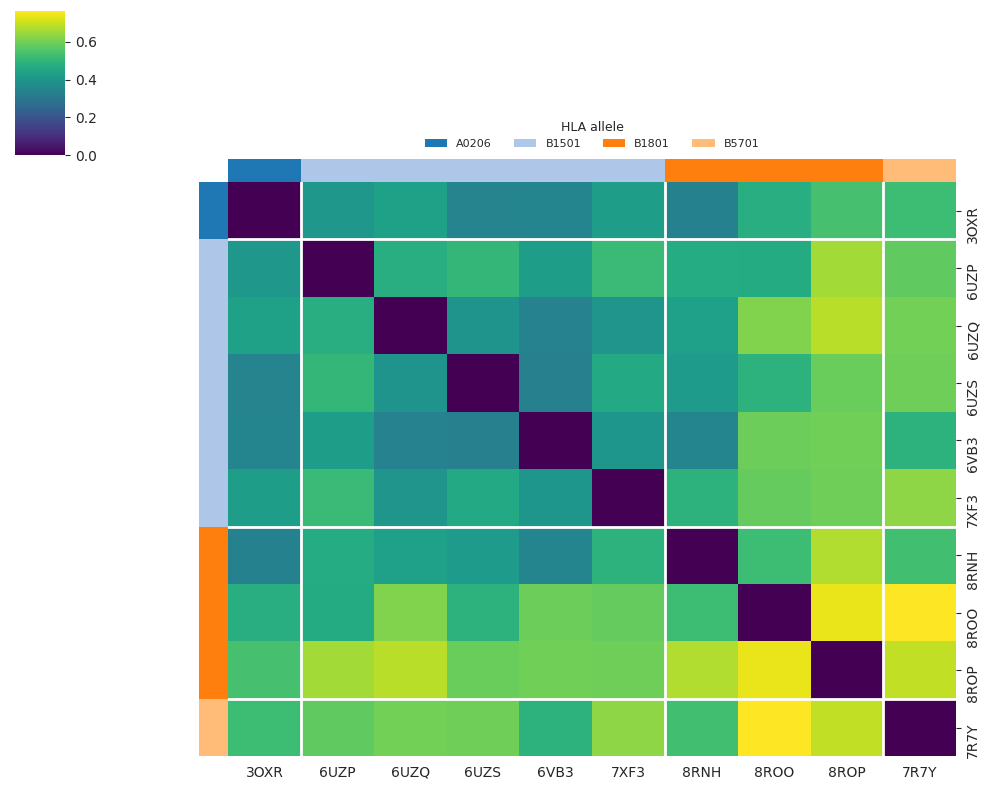

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import entropy           # only needed if you build JS here

# ------------------------------------------------------------------
# 0 .  (Optional) build JS-distance matrix once
# ------------------------------------------------------------------
# Suppose “pwm_df” is a DataFrame whose rows are PDB IDs and whose columns
# are the flattened 9×20 PWM probabilities.  One way to get the square
# JS matrix is:
#
# def js(p, q):
#     m = 0.5 * (p + q)
#     return 0.5*entropy(p, m, base=2) + 0.5*entropy(q, m, base=2)
#
# pwm_js = pd.DataFrame(
#     squareform(pdist(pwm_df.values, metric=js)),
#     index=pwm_df.index, columns=pwm_df.index
# )
# ------------------------------------------------------------------
# If you already have it, just ensure the variable is called pwm_js.
# ------------------------------------------------------------------

# -------------------------------------------------------------
# 1 .  Map every PDB to its HLA allele
# -------------------------------------------------------------
mask = merged_dt['plddt_x'] > 0.6
pdb2hla = (merged_dt.loc[mask, ['pdb_id', 'hla_allele_x']]
                    .dropna(subset=['hla_allele_x'])
                    .drop_duplicates('pdb_id')
                    .set_index('pdb_id')['hla_allele_x'])

# Only keep PDBs present in the JS matrix
common_idx = pwm_js.index.intersection(pdb2hla.index)
pwm_js     = pwm_js.loc[common_idx, common_idx]
pdb2hla    = pdb2hla.reindex(common_idx).fillna('UNK')

# -------------------------------------------------------------
# 2 .  Order matrix rows/cols by HLA, then by PDB
# -------------------------------------------------------------
order     = pdb2hla.sort_values(kind='mergesort').index
M         = pwm_js.loc[order, order]
hla_order = pdb2hla.loc[order]

# -------------------------------------------------------------
# 3 .  Stripe colours
# -------------------------------------------------------------
unique_hla    = hla_order.unique()
palette       = sns.color_palette('tab20', len(unique_hla))
color_map     = dict(zip(unique_hla, palette))
stripe_colors = hla_order.map(color_map).to_numpy()

# -------------------------------------------------------------
# 4 .  Heat-map (no clustering, JS divergence)
# -------------------------------------------------------------
g = sns.clustermap(
        M,
        cmap='viridis',
        row_cluster=False, col_cluster=False,
        row_colors=stripe_colors, col_colors=stripe_colors,
        linewidths=0.0,
        figsize=(10, 8)
    )

# -------------------------------------------------------------
# 5 .  White grid lines between HLA blocks
# -------------------------------------------------------------
group_sizes = hla_order.value_counts(sort=False).loc[unique_hla].to_numpy()
cuts = np.cumsum(group_sizes)
for cut in cuts[:-1]:
    g.ax_heatmap.axhline(cut, color='white', lw=2)
    g.ax_heatmap.axvline(cut, color='white', lw=2)

# -------------------------------------------------------------
# 6 .  Legend
# -------------------------------------------------------------
for hla, col in color_map.items():
    g.ax_col_dendrogram.bar(0, 0, color=col, label=hla, linewidth=0)

g.ax_col_dendrogram.legend(
    loc='lower center',
    ncol=min(10, len(unique_hla)),
    title='HLA allele',
    frameon=False,
    fontsize=8,
    title_fontsize=9
)

# -------------------------------------------------------------
# 7 .  Save figure
# -------------------------------------------------------------
out_dir = '/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/figures/'
os.makedirs(out_dir, exist_ok=True)
plt.savefig(os.path.join(out_dir, 'HLA_MATRIX_JS.pdf'), bbox_inches='tight')
plt.show()
